In [1]:
import numpy as np
import pandas as pd
import itertools
#from tqdm import tqdm
import matplotlib.pyplot as plt
#from pandas_datareader import data as web
plt.style.use("default")
import re
import requests
from bs4 import BeautifulSoup
# For reproducibility
np.random.seed(42)


In [ ]:
# Manually maintain this list as you go
leverage_pairs = [
    ("AAPU", "AAPL"),
    ("AMUU", "AMD"),
    ("AMZU", "AMZN"),
    ("AVL", "AVGO"),
    ("BITX", "IBIT"),
    ("BOEU", "BA"),
    ("BRKU", "BRK-B"),
    ("BULU", "BULL"),
    ("CSCL", "CSCO"),
    ("ELIL", "LLY"),
    ("ETHU", "ETHA"),
    ("FRDU", "F"),
    ("GGLL", "GOOGL"),
    ("GMEU", "GME"),
    ("LMTL", "LMT"),
    ("METU", "META"),
    ("MUU", "MU"),
    ("MSFU", "MSFT"),
    ("MSTX", "MSTR"),
    ("NVDU", "NVDA"),
    ("NFXL", "NFLX"),
    ("PLTU", "PLTR"),
    ("PALU", "PANW"),
    ("QCMU", "QCOM"),
    ("SHPU", "SHOP"),
    ("TSMX", "TSM"),
    ("TSLL", "TSLA"),
    ("XOMX", "XOM"),
    ("XXRP", "XRPZ")
]

leverage_pairs_leverageshares = [
    ("AALG", "AAL"),
    ("ABNG", "ABNB"),
    ("ADBG", "ADBE"),
    ("AMDG", "AMD"),
    ("ARMG", "ARM"),
    ("ASMG", "ASML"),
    ("AVGG", "AVGO"),
    ("BAIG", "BBAI"),
    ("BEG", "BE"),
    ("BIDG", "BIDU"),
    ("BLSG", "BLSH"),
    ("BMNG", "BMNR"),
    ("BOEG", "BA"),
    ("BULG", "BULL"),
    ("CIFG", "CIFR"),
    ("CMGG", "CMG"),
    ("CNCG", "CNC"),
    ("COIG", "COIN"),
    ("COTG", "COST"),
    ("CRCG", "CRCL"),
    ("CRMG", "CRM"),
    ("CRWG", "CRWV"),
    ("DUOG", "DUOL"),
    ("FIGG", "FIG"),
    ("FUTG", "FUTU"),
    ("GEMG", "GEMI"),
    ("GEVG", "GEV"),
    ("GLGG", "GLXY"),
    ("GRAG", "GRAB"),
    ("HOOG", "HOOD"),
    ("IREG", "IREN"),
    ("KLAG", "KLAC"),
    ("LACG", "LAC"),
    ("LULG", "LULU"),
    ("MPG", "MP"),
    ("NBIG", "NBIS"),
    ("NEMG", "NEM"),
    ("NETG", "NET"),
    ("NIOG", "NIO"),
    ("NUG", "NU"),
    ("NVDG", "NVDA"),
    ("OKTG", "OKTA"),
    ("OPEG", "OPEN"),
    ("OSCG", "OSCR"),
    ("PANG", "PANW"),
    ("PBRG", "PBR"),
    ("PLTG", "PLTR"),
    ("PYPG", "PYPL"),
    ("RTXG", "RTX"),
    ("SATG", "SATS"),
    ("SBU", "SBUX"),
    ("SNAG", "SNAP"),
    ("SPOG", "SPOT"),
    ("TERG", "TER"),
    ("TSLG", "TSLA"),
    ("TSMG", "TSM"),
    ("UNHG", "UNH"),
    ("UPSG", "UPS"),
    ("VALG", "VALE"),
    ("XYZG", "XYZ"),
]


# --- New pairs (with crypto mapped to IBIT / ETHA) ---
new_pairs = [
    ("MSTU", "MSTR"),
    ("NVDX", "NVDA"),
    ("TSLT", "TSLA"),
    ("BTCL", "IBIT"),   # changed from BTC -> IBIT
    ("ETU",  "ETHA"),   # changed from ETH -> ETHA
    ("CCUP", "CRCL"),
    ("CRWU", "CRWV"),
    ("AAPX", "AAPL"),
    ("GOOX", "GOOGL"),
    ("MSFX", "MSFT"),
    ("NFLU", "NFLX"),
    ("ROBN", "HOOD"),
    ("ARMU", "ARM"),
    ("DJTU", "DJT"),
    ("RBLU", "RBLX"),
    ("SNOU", "SNOW"),
    ("SMUP", "SMR"),
    ("DKUP", "DKNG"),
    ("BULU", "BULL"), 
    ("GLXU", "GLXY"),
    ("AFRU", "AFRM"),
    ("AXUP", "AXON"),
    ("KTUP", "KTOS"),
    ("TTDU", "TTD"),
    ("BKNU", "BKNG"),
    ("PXIU", "UPXI"),
    ("BMNU", "BMNR"),
    ("SBTU", "SBET"),
    ("CIFU", "CIFR"),
    ("SOLX", "GSOL"),
    ("XRPK", "XRPZ"),
    ("GMEU", "GME"),
    ("APLX", "APLD"),
    ("APPX", "APP"),
    ("ARCX", "ACHR"),
    ("ASTX", "ASTS"),
    ("AURU", "AUR"),
    ("BEX", "BE"),
    ("BLSX", "BLSH"),
    ("CEGX", "CEG"),
    ("CELT", "CELH"),
    ("CLSX", "CLSK"),
    ("COZX", "CORZ"),
    ("CRDU", "CRDO"),
    ("CSEX", "CLS"),
    ("CWVX", "CRWV"),
    ("DASX", "DASH"),
    ("DOGD", "DDOG"),
    ("ENPX", "ENPH"),
    ("FLYT", "FLY"),
    ("GEVX", "GEV"),
    ("GSX", "GS"),
    ("IREX", "IREN"),
    ("JOBX", "JOBY"),
    ("LABX", "ALAB"),
    ("LRCU", "LRCX"),
    ("LYFX", "LYFT"),
    ("MDBX", "MDB"),
    ("NEBX", "NBIS"),
    ("NETX", "NET"),
    ("NNEX", "NNE"),
    ("NVTX", "NVTS"),
    ("NWMX", "NEM"),
    ("OKTX", "OKTA"),
    ("OPEX", "OPEN"),
    ("PONX", "PONY"),
    ("QBTX", "QBTS"),
    ("QSX", "QS"),
    ("QUBX", "QUBT"),
    ("RGTU", "RGTI"),
    ("SMU", "SMR"),
    ("SNPX", "SNPS"),
    ("SRPU", "SRPT"),
    ("TARK", "ARKK"),
    ("TEMT", "TEM"),
    ("UNX", "U"),
    ("UPSX", "UPST"),
    ("VOYX", "VOYG"),
    ("WULX", "WULF"),
    ("ASMU", "ASML"),  # Direxion Daily ASML Bull 2X
    ("BABU", "BABA"),  # Direxion Daily BABA Bull 2X
    ("MRVU", "MRVL"),  # Direxion Daily MRVL Bull 2X
    ("SOFA", "SOFI"),  # Direxion Daily SOFI Bull 2X
    ("CRMU", "CRML"),  # Leverage Shares 2X Long CRML
    ("UECG", "UEC"),   # Leverage Shares 2X Long UEC
    ("DNNG", "DNN"),   # Leverage Shares 2X Long DNN
    ("RCAX", "RCAT"),  # Defiance Daily Target 2X Long RCAT
    ("RDWU", "RDW"),   # T-REX 2X Long RDW Daily Target
    ("OKLL", "OKLO"),  # Defiance Daily Target 2X Long OKLO
]

proshares_pairs_levered = [
    ("CRCA", "CRCL"),
    ("NVDB", "NVDA"),
    ("PLTA", "PLTR"),
    ("TSLI", "TSLA"),
    ("COIA", "COIN"),
    ("BITU", "IBIT"),
    ("ETHT", "ETHA"),
    ("UXRP", "XRPZ"),
    ("SOLT", "SOEZ")
]

graniteshares_pairs_leveraged = [
    ("TSLR", "TSLA"),   # 2x TSLA
    ("AAPB", "AAPL"),
    ("AMDL", "AMD"),
    ("AMZZ", "AMZN"),
    ("AVGU", "AVGO"),
    ("BABX", "BABA"),
    ("BULX", "BULL"),
    ("CONL", "COIN"),
    ("CRWL", "CRWD"),
    ("DLLL", "DELL"),
    ("ETRL", "ETOR"),
    ("GOU",  "GOOGL"),
    ("INTW", "INTC"),
    ("IONL", "IONQ"),
    ("ISUL", "ISRG"),
    ("LCDL", "LCID"),
    ("MRAL", "MARA"),
    ("FBL",  "META"),
    ("MVLL", "MRVL"),
    ("MSFL", "MSFT"),
    ("MSTP", "MSTR"),
    ("MULL", "MU"),
    ("NBIL", "NBIS"),
    ("NOWL", "NOW"),
    ("NVDL", "NVDA"),
    ("PDDL", "PDD"),
    ("PTIR", "PLTR"),
    ("QCML", "QCOM"),
    ("RDTL", "RDDT"),
    ("RVNL", "RIVN"),
    ("SMCL", "SMCI"),
    ("TSMU", "TSM"),
    ("UBRL", "UBER"),
    ("VRTL", "VRT"),
    ("AMYY", "AMD"),
    ("AZYY", "AMZN"),
    ("BBYY", "BABA"),
    ("XBTY", "IBIT"),     # Bitcoin
    ("COYY", "COIN"),
    ("NUGY", "GDX"),     # Gold Miners (proxy)
    ("HMYY", "HIMS"),
    ("HOYY", "HOOD"),
    ("IOYY", "IONQ"),
    ("MAAY", "MARA"),
    ("FBYY", "META"),
    ("MTYY", "MSTR"),
    ("NVYY", "NVDA"),
    ("PLYY", "PLTR"),
    ("QBY",  "QBTS"),
    ("TQQY", "QQQ"),
    ("RGYY", "RGTI"),
    ("RTYY", "RIOT"),
    ("SEMY", "SOXX"),    # Semiconductor ETF (proxy)
    ("SMYY", "SMCI"),
    ("YSPY", "SPY"),
    ("TSYY", "TSLA"),
]

leverage_pairs_capped_accel = [
    ("COIO", "COIN"),
    ("MSOO", "MSTR"),
    ("NVDO", "NVDA"),
    ("PLOO", "PLTR"),
    ("TSLO", "TSLA"),
]

# --- Add them without allowing duplicate ETFs (but allow duplicate underlyings) ---
existing_etfs = {etf for etf, _ in leverage_pairs}
leverage_pairs += [(etf, und) for etf, und in new_pairs if etf not in existing_etfs]

# --- Rebuild expanded list WITHOUT filtering on underlying; only prevent duplicate ETF tickers ---
def dedupe_by_etf(pairs):
    seen = set()
    out = []
    for etf, und in pairs:
        if etf in seen:
            continue
        seen.add(etf)
        out.append((etf, und))
    return out

leverage_pairs_expanded = dedupe_by_etf(
    leverage_pairs
    + leverage_pairs_leverageshares
    + leverage_pairs_capped_accel
    + proshares_pairs_levered
    + graniteshares_pairs_leveraged
)


dx_df = pd.DataFrame(
    [
        {"ETF": etf, "Underlying": und}
        for etf, und in leverage_pairs_expanded
    ]
)

dx_df["Leverage"] = 2.0   # 2x for these dx leveraged products

In [3]:
covered_call_pairs_expanded = [
    ("QYLD", "QQQ"),   # Global X full overwrite
    ("QYLG", "QQQ"),   # 50% overwrite
    ("QQQX", "QQQ"),   # Nuveen dynamic overwrite
    ("JEPQ", "QQQ"),   # JPM active Nasdaq covered-call
    ("XYLD", "SPY"),   # S&P 500 buy-write
    ("XYLG", "SPY"),   # 50% overwrite
    ("JEPI", "SPY"),   # JPM ELN-based premium income
    ("SPYI", "SPY"),   # NEOS buy-write
    ("RYLD", "IWM"),   # Russell 2000 buy-write
]

cc_df = pd.DataFrame(
    [
        {"ETF": etf, "Underlying": und}
        for etf, und in covered_call_pairs_expanded
    ]
)

cc_df["Leverage"] = 1.0   # treat covered calls as 1x


session = requests.Session()
session.headers.update(
    {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        )
    }
)

def get_yieldmax_single_stock_map():
    """
    Scrapes the YieldMax Single Stock Option Income ETFs page and extracts
    (ETF ticker, underlying stock) from the ETF name, e.g.:

        Ticker:  TSLY
        Name:    'YieldMax TSLA Option Income Strategy ETF'
        -> underlying = TSLA

    Returns: DataFrame with columns [Provider, ETF, Underlying]
    """
    base = "https://yieldmaxetfs.com"
    url = base + "/nav-group/yieldmax-single-stock-option-income-etfs/"

    resp = session.get(url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")

    rows = []

    # For each link that looks like a ticker, find the nearby 'YieldMax ...' name
    for a in soup.find_all("a", href=True):
        ticker = a.get_text(strip=True)

        # Tickers are 3–5 uppercase letters (ABNY, TSLY, NVDY, etc.)
        if not re.fullmatch(r"[A-Z]{3,5}", ticker):
            continue

        # Find the ETF name text that follows this ticker
        name_node = a.find_next(string=re.compile(r"^YieldMax "))
        if not name_node:
            continue

        etf_name = name_node.strip()

        # Try to extract underlying from the name:
        # 'YieldMax TSLA Option Income Strategy ETF' -> TSLA
        # 'YieldMax AMZN Option Income ETF'         -> AMZN
        m = re.search(r"YieldMax\s+([A-Z\.]{2,6})\s+Option Income", etf_name)
        if not m:
            continue

        underlying = m.group(1)

        rows.append(("YieldMax", ticker, underlying))

    df = pd.DataFrame(rows, columns=["Provider", "ETF", "Underlying"])
    df = df.drop_duplicates().sort_values(["Provider", "ETF"]).reset_index(drop=True)
    df = df.drop(columns=["Provider"])
    return df

ym_df = get_yieldmax_single_stock_map()
ym_df["Leverage"] = 1.0   # treat YieldMax as 1x (income overlay, not levered beta)



In [4]:
BAD_TOKENS = {
    "NEW", "ETF", "ETFS", "WEEKLYPAY", "WEEKLY", "PAY",
    "ISSUE", "TREASURY", "INCOME", "STRATEGY", "FUND", "TRUST", "INC"
}

def get_roundhill_weeklypay_single_stock_map():
    """
    Scrapes Roundhill WeeklyPay ETFs page and extracts (ETF, Underlying).

    Logic:
    - Identify WeeklyPay link entries
    - Parse first token as ETF
    - Find the first subsequent token that looks like a ticker (2–6 chars, all caps, allows '.' and '-')
      and is not a known bad token
    - If no such token exists, fallback to ETF[:-1] when ETF ends with 'W' (e.g. TSYW -> TSY)
    """
    url = "https://www.roundhillinvestments.com/weeklypay-etfs"

    resp = session.get(url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")

    rows = []

    ticker_re = re.compile(r"^[A-Z][A-Z0-9\.\-]{1,5}$")  # e.g., AAPL, BRK.B, BRK-B

    for a in soup.find_all("a", href=True):
        txt = " ".join(a.get_text(" ", strip=True).split())
        if not txt or "WeeklyPay" not in txt:
            continue

        parts = txt.split()
        if len(parts) < 2:
            continue

        etf = parts[0]
        if not re.fullmatch(r"[A-Z]{3,5}W", etf) and etf != "WPAY":
            # WPAY is a WeeklyPay fund but not single-stock; keep your choice here.
            # We'll ignore it by default.
            continue
        if etf == "WPAY":
            continue

        # Look for an explicit underlying ticker anywhere after the ETF token
        underlying = None
        for tok in parts[1:8]:  # scan a few tokens; enough for current formatting
            t = tok.strip("®™:,;()[]")
            if not ticker_re.fullmatch(t):
                continue
            if t in BAD_TOKENS:
                continue
            if t == etf:
                continue
            underlying = t
            break

        # Fallback: some entries omit the underlying ticker; use ETF[:-1] when it ends in W
        if underlying is None and etf.endswith("W"):
            underlying = etf[:-1]

        if underlying is None:
            continue

        rows.append((etf, underlying))

    df = pd.DataFrame(rows, columns=["ETF", "Underlying"])
    return df.drop_duplicates().sort_values("ETF").reset_index(drop=True)


rh_df = get_roundhill_weeklypay_single_stock_map()
# -----------------------------
# Post-scrape overrides for known bad mappings
# -----------------------------
ROUNDHILL_UNDERLYING_OVERRIDES = {
    "TSYW": "TLT",     # WeeklyPay Treasury -> long-duration Treasury ETF
    "BRKW": "BRK-B",   # Fix Yahoo-compatible Berkshire ticker
}

rh_df["Underlying"] = rh_df.apply(
    lambda r: ROUNDHILL_UNDERLYING_OVERRIDES.get(r["ETF"], r["Underlying"]),
    axis=1
)

rh_df["Leverage"] = 1.0  # treat WeeklyPay as 1x (income overlay, not levered beta)
income_df = pd.concat([cc_df, ym_df, rh_df], ignore_index=True)

In [5]:
all_df = pd.concat([dx_df, income_df], ignore_index=True)
# make sure to exclude jp morgan
all_df = all_df.dropna(subset=["Underlying"])
all_df = all_df[all_df["Underlying"].astype(str).str.strip() != ""]

# Drop duplicate ETFs or duplicate rows if needed
all_df = all_df.drop_duplicates(subset=["ETF"]).reset_index(drop=True)
# Replace dots with dashes for Yahoo Finance compatibility
all_df["ETF"] = all_df["ETF"].str.replace(".", "-", regex=False)
all_df["Underlying"] = all_df["Underlying"].str.replace(".", "-", regex=False)

# Now create clean ticker lists
all_tickers = all_df["ETF"].tolist()
all_underlyings = all_df["Underlying"].tolist()

# UNIQUE list of underlyings
all_underlyings_unique = sorted(set(all_underlyings))

print("Clean DataFrame:")
print(all_df)

print("\nUnique underlyings:")
print(all_underlyings_unique)

Clean DataFrame:
      ETF Underlying  Leverage
0    AAPU       AAPL       2.0
1    AMUU        AMD       2.0
2    AMZU       AMZN       2.0
3     AVL       AVGO       2.0
4    BITX       IBIT       2.0
..    ...        ...       ...
298  PLTW       PLTR       1.0
299  TSLW       TSLA       1.0
300  TSYW        TLT       1.0
301  UBEW       UBER       1.0
302  UNHW        UNH       1.0

[303 rows x 3 columns]

Unique underlyings:
['AAL', 'AAPL', 'ABNB', 'ACHR', 'ADBE', 'AFRM', 'AI', 'ALAB', 'AMD', 'AMZN', 'APLD', 'APP', 'ARKK', 'ARM', 'ASML', 'ASTS', 'AUR', 'AVGO', 'AXON', 'BA', 'BABA', 'BBAI', 'BE', 'BIDU', 'BKNG', 'BLSH', 'BMNR', 'BRK-B', 'BULL', 'CEG', 'CELH', 'CIFR', 'CLS', 'CLSK', 'CMG', 'CNC', 'COIN', 'CORZ', 'COST', 'CRCL', 'CRDO', 'CRM', 'CRWD', 'CRWV', 'CSCO', 'CVNA', 'DASH', 'DDOG', 'DELL', 'DIS', 'DJT', 'DKNG', 'DUOL', 'ENPH', 'ETHA', 'ETOR', 'F', 'FIG', 'FLY', 'FUTU', 'GDX', 'GEMI', 'GEV', 'GLXY', 'GME', 'GOLD', 'GOOGL', 'GRAB', 'GS', 'GSOL', 'HIMS', 'HOOD', 'IBIT', 'INTC',

In [6]:
# 2. Build the universe_df with just the fields we care about
universe_cols = ["Underlying", "ETF", "Leverage"]
universe_df = all_df[universe_cols].copy()

# (optional) sort for readability
universe_df = universe_df.sort_values(["Underlying", "ETF"]).reset_index(drop=True)

print("Universe DataFrame:")
print(universe_df.head())

# 3. Export to CSV
universe_df.to_csv("etf_universe.csv", index=False)
print("\nSaved ETF universe to etf_universe.csv")


Universe DataFrame:
  Underlying   ETF  Leverage
0        AAL  AALG       2.0
1       AAPL  AAPB       2.0
2       AAPL  AAPU       2.0
3       AAPL  AAPW       1.0
4       AAPL  AAPX       2.0

Saved ETF universe to etf_universe.csv


In [7]:
import builtins
import numpy as np
import pandas as pd
import yfinance as yf

def norm_ticker_safe(x) -> str:
    # builtins.str avoids notebook shadowing like: str="foo"
    t = builtins.str(x).strip().upper().replace(".", "-")
    crypto_map = {
        "BTC": "IBIT",
        "ETH": "ETHA",
        "XRP": "XRP",
        "SOL": "SOEZ",
    }
    return crypto_map.get(t, t)

def ols_beta_from_returns(etf_ret: pd.Series, und_ret: pd.Series):
    z = pd.concat([etf_ret, und_ret], axis=1).dropna()
    n = int(z.shape[0])
    if n < 2:
        return (np.nan, n)

    y = z.iloc[:, 0].to_numpy()
    x = z.iloc[:, 1].to_numpy()

    x_var = np.var(x, ddof=1)
    if not np.isfinite(x_var) or x_var == 0:
        return (np.nan, n)

    cov = np.cov(x, y, ddof=1)[0, 1]
    b = cov / x_var
    if not np.isfinite(b):
        return (np.nan, n)

    return (float(b), n)

def add_pair_betas_full_history_always(
    all_df: pd.DataFrame,
    start=None,
    end=None,
    short_history_n=30,
    output_csv_path="all_pairs_with_betas.csv",
    cache_prices=True,
):
    df = all_df.copy()
    df = df.dropna(subset=["ETF", "Underlying"]).reset_index(drop=True)

    # Normalize tickers WITHOUT pandas apply/map
    etfs = [norm_ticker_safe(x) for x in df["ETF"].tolist()]
    unds = [norm_ticker_safe(x) for x in df["Underlying"].tolist()]
    df["ETF"] = etfs
    df["Underlying"] = unds

    # Expected leverage fallback
    if "Leverage" in df.columns:
        lev = pd.to_numeric(df["Leverage"], errors="coerce").fillna(2.0).astype(float)
        df["ExpectedLeverage"] = lev
    else:
        df["ExpectedLeverage"] = 2.0

    px_cache = {}  # ticker -> Adj Close series

    def get_series(ticker: str) -> pd.Series:
        ticker = norm_ticker_safe(ticker).upper()
        if cache_prices and ticker in px_cache:
            return px_cache[ticker]

        kwargs = dict(auto_adjust=False, progress=False)

        try:
            if start is None and end is None:
                h = yf.download(ticker, period="max", **kwargs)
            else:
                h = yf.download(ticker, start=start, end=end, **kwargs)
        except Exception:
            h = pd.DataFrame()

        if h is None or h.empty or "Adj Close" not in h.columns:
            s = pd.Series(dtype=float, name=ticker)
        else:
            s = h["Adj Close"].dropna()
            s.name = ticker

        if cache_prices:
            px_cache[ticker] = s
        return s

    betas, nobs, sources = [], [], []

    # Loop pairwise on FULL overlap
    for i in range(len(df)):
        etf = df.at[i, "ETF"]
        und = df.at[i, "Underlying"]
        exp = float(df.at[i, "ExpectedLeverage"])

        s_etf = get_series(etf)
        s_und = get_series(und)

        if s_etf.empty or s_und.empty:
            betas.append(exp)
            nobs.append(0)
            sources.append("imputed_missing_prices")
            continue

        px_pair = pd.concat([s_etf, s_und], axis=1).dropna(how="any")
        px_pair.columns = [etf, und]

        if px_pair.shape[0] < 3:
            betas.append(exp)
            nobs.append(max(int(px_pair.shape[0]) - 1, 0))
            sources.append("imputed_no_overlap")
            continue

        rets = px_pair.pct_change().replace([np.inf, -np.inf], np.nan).dropna()
        b, n = ols_beta_from_returns(rets[etf], rets[und])

        if not np.isfinite(b) or n < 2:
            betas.append(exp)
            nobs.append(int(n))
            sources.append("imputed_no_overlap")
            continue

        betas.append(float(b))
        nobs.append(int(n))
        sources.append("ols_short_history" if n < short_history_n else "ols")

    df["Beta"] = betas
    df["Beta_n_obs"] = nobs
    df["Beta_source"] = sources

    df.to_csv(output_csv_path, index=False)
    print(
        f"Saved {output_csv_path} | rows={len(df)} | "
        f"ols={(df['Beta_source']=='ols').sum()} | "
        f"ols_short={(df['Beta_source']=='ols_short_history').sum()} | "
        f"imputed={(df['Beta_source'].str.startswith('imputed')).sum()}"
    )
    return df

# RUN
pairs_with_betas = add_pair_betas_full_history_always(
    all_df=all_df,
    start=None,
    end=None,
    short_history_n=30,
    output_csv_path="all_pairs_with_betas.csv",
    cache_prices=True,
)

display(pairs_with_betas.head(20))
print("Any NaN betas?", pairs_with_betas["Beta"].isna().any())
print(pairs_with_betas["Beta_source"].value_counts())


Saved all_pairs_with_betas.csv | rows=303 | ols=303 | ols_short=0 | imputed=0


,ETF,Underlying,Leverage,ExpectedLeverage,Beta,Beta_n_obs,Beta_source
0,AAPU,AAPL,2.0,2.0,1.779375,880,ols
1,AMUU,AMD,2.0,2.0,2.007300,215,ols
2,AMZU,AMZN,2.0,2.0,1.730584,860,ols
3,AVL,AVGO,2.0,2.0,1.986840,334,ols
4,BITX,IBIT,2.0,2.0,2.000687,522,ols
5,BOEU,BA,2.0,2.0,1.990614,202,ols
6,BRKU,BRK-B,2.0,2.0,1.950906,291,ols
7,BULU,BULL,2.0,2.0,1.974526,134,ols
8,CSCL,CSCO,2.0,2.0,2.011196,159,ols
9,ELIL,LLY,2.0,2.0,1.992821,220,ols


Any NaN betas? False
Beta_source
ols    303
Name: count, dtype: int64


In [80]:
pd.DataFrame({"ticker": all_tickers}).to_csv("tickers.csv", index=False)


In [29]:
import ftplib

ftp = ftplib.FTP("ftp2.interactivebrokers.com")
ftp.login(user="shortstock", passwd="")  # password is blank / anonymous

files = ftp.nlst()
print(files)

ftp.quit()


['australia.txt', 'australia.txt.md5', 'austria.txt', 'austria.txt.md5', 'belgium.txt', 'belgium.txt.md5', 'british.txt', 'british.txt.md5', 'canada.txt', 'canada.txt.md5', 'dutch.txt', 'dutch.txt.md5', 'france.txt', 'france.txt.md5', 'germany.txt', 'germany.txt.md5', 'hongkong.txt', 'hongkong.txt.md5', 'india.txt', 'india.txt.md5', 'italy.txt', 'italy.txt.md5', 'japan.txt', 'japan.txt.md5', 'mexico.txt', 'mexico.txt.md5', 'singapore.txt', 'singapore.txt.md5', 'spain.txt', 'spain.txt.md5', 'stockmargin_final_dtls.IB-AU.dat', 'stockmargin_final_dtls.IB-AU.dat.md5', 'stockmargin_final_dtls.IB-CAN.dat', 'stockmargin_final_dtls.IB-CAN.dat.md5', 'stockmargin_final_dtls.IB-HK.dat', 'stockmargin_final_dtls.IB-HK.dat.md5', 'stockmargin_final_dtls.IB-IN.dat', 'stockmargin_final_dtls.IB-IN.dat.md5', 'stockmargin_final_dtls.IB-JP.dat', 'stockmargin_final_dtls.IB-JP.dat.md5', 'stockmargin_final_dtls.IB-SG.dat', 'stockmargin_final_dtls.IB-SG.dat.md5', 'stockmargin_final_dtls.IB-UKL.dat', 'stockmarg

'221 Goodbye.'

In [30]:
import ftplib
import io

def fetch_ibkr_shortstock_file(filename="usa.txt") -> pd.DataFrame:
    ftp = ftplib.FTP("ftp2.interactivebrokers.com")
    ftp.login(user="shortstock", passwd="")

    buf = io.BytesIO()
    ftp.retrbinary(f"RETR {filename}", buf.write)
    ftp.quit()

    buf.seek(0)
    text = buf.getvalue().decode("utf-8", errors="ignore")
    lines = [ln for ln in text.splitlines() if ln.strip()]

    # Find the header line that starts with #SYM|
    header_idx = None
    for i, ln in enumerate(lines):
        if ln.startswith("#SYM|"):
            header_idx = i
            break
    if header_idx is None:
        raise ValueError("Could not find header line starting with '#SYM|'")

    header_line = lines[header_idx]
    data_lines = lines[header_idx + 1:]

    # Build column names from header
    header_cols = [c.strip().lstrip("#").lower() for c in header_line.split("|")]

    # Join data lines back to a CSV-like string
    data_str = "\n".join(data_lines)
    data_buf = io.StringIO(data_str)

    # Read data; allow Python engine for safety
    df = pd.read_csv(
        data_buf,
        sep="|",
        header=None,
        engine="python"
    )

    # Trim / align columns
    n_cols = min(len(header_cols), df.shape[1])
    df = df.iloc[:, :n_cols]
    df.columns = header_cols[:n_cols]

    # Drop any empty / unnamed trailing columns
    df = df.drop(columns=[c for c in df.columns if not c or str(c).startswith("unnamed")], errors="ignore")

    return df


In [31]:
short_df = fetch_ibkr_shortstock_file("usa.txt")
short_df.head()


,sym,cur,name,con,isin,rebaterate,feerate,available,figi
0,A,USD,AGILENT TECHNOLOGIES INC,1715006.0,XXXXXXXU1016,3.3510,0.2891,5200000,BBG000C2V3D6
1,AA,USD,ALCOA CORP,251962528.0,XXXXXXX21065,3.2319,0.4081,6300000,BBG00B3T3HD3
2,AAA,USD,ALTERNATIVE ACCESS FIRST PRI,591368776.0,XXXXXXXX6105,-0.1221,3.7621,75000,BBG01B0JRCS6
3,AAAA,USD,AMPLIUS AGGRESSIVE A ALL ETF,799151665.0,XXXXXXXQ6897,-71.6283,75.2683,90000,BBG01W275XX6
4,AAAC,USD,COLUMBIA AAA CLO ETF,837910779.0,XXXXXXXL7635,NaN,NaN,35000,BBG01YZNRVY0


In [32]:
short_df.columns

Index(['sym', 'cur', 'name', 'con', 'isin', 'rebaterate', 'feerate',
       'available', 'figi'],
      dtype='object')

In [33]:
import numpy as np

def build_ibkr_short_maps(
    tickers,
    filename="usa.txt",
    default_borrow=0.05,   # 5% if not found
    default_rebate=0.0
):
    """
    Use IBKR's public shortstock FTP file to build:
      - net borrow rate map (fee - rebate)
      - rebate rate map
      - available-shares map

    All rates returned as decimals (e.g. 0.12 = 12% per year).
    """
    tickers = [t.upper() for t in tickers]

    short_df = fetch_ibkr_shortstock_file(filename)

    # Clean / normalize columns
    short_df["sym"] = short_df["sym"].astype(str).str.upper().str.strip()

    # Some files are in percent (e.g. 3.6300 means 3.63%)
    # Convert to decimals
    short_df["rebate_annual"] = pd.to_numeric(short_df["rebaterate"], errors="coerce") / 100.0
    short_df["fee_annual"]    = pd.to_numeric(short_df["feerate"],    errors="coerce") / 100.0
    short_df["available_int"] = pd.to_numeric(short_df["available"],  errors="coerce")

    # Net borrow cost to you ≈ fee - rebate.
    # If this goes negative (i.e. you actually earn carry),
    # you can either keep it or clip at 0. I'll clip at 0 to be conservative.
    short_df["net_borrow_annual"] = short_df["fee_annual"] - short_df["rebate_annual"]
    short_df["net_borrow_annual"] = short_df["net_borrow_annual"].clip(lower=0)

    # Filter only the symbols we care about
    mask = short_df["sym"].isin(tickers)
    sub = short_df.loc[mask].copy()

    borrow_map = {}
    rebate_map = {}
    available_map = {}

    for _, row in sub.iterrows():
        sym = row["sym"]
        if pd.notna(row["net_borrow_annual"]):
            borrow_map[sym] = float(row["net_borrow_annual"])
        if pd.notna(row["rebate_annual"]):
            rebate_map[sym] = float(row["rebate_annual"])
        if pd.notna(row["available_int"]):
            available_map[sym] = int(row["available_int"])

    # Defaults for anything missing
    borrow_map["default"] = default_borrow
    rebate_map["default"] = default_rebate

    return borrow_map, rebate_map, available_map


In [34]:
borrow_map, rebate_map, available_map = build_ibkr_short_maps(
    tickers=all_tickers,
    filename="usa.txt",
    default_borrow=0.05,
    default_rebate=0.0
)

borrow_map


{'AAPB': 0.05457200000000001,
 'AAPU': 0.07350999999999999,
 'AAPW': 0.242676,
 'AAPX': 0.122886,
 'ABNG': 0.21565,
 'ABNY': 0.037038,
 'ADBG': 0.147034,
 'AFRU': 0.210238,
 'AIYY': 0.145968,
 'AMDG': 0.045022000000000006,
 'AMDL': 0.02843,
 'AMDW': 0.14871,
 'AMDY': 0.030978,
 'AMUU': 0.0,
 'AMZU': 0.064946,
 'AMZW': 0.023744,
 'AMZY': 0.048246000000000004,
 'AMZZ': 0.001962000000000002,
 'APLX': 0.28346000000000005,
 'APLY': 0.133178,
 'ARCX': 0.207826,
 'ARMG': 0.336502,
 'ARMU': 0.487912,
 'ARMW': 0.071952,
 'ASMG': 0.212042,
 'ASTX': 0.241738,
 'AVGG': 0.109438,
 'AVGU': 0.229182,
 'AVGW': 0.21005600000000002,
 'AVL': 0.05809,
 'AXUP': 0.164822,
 'BABO': 0.041403999999999996,
 'BABW': 0.13594,
 'BABX': 0.0,
 'BAIG': 0.28595,
 'BEG': 0.36966,
 'BEX': 0.250442,
 'BIDG': 0.19499,
 'BITU': 0.0,
 'BITX': 0.09019200000000001,
 'BKNU': 0.13164800000000002,
 'BLSG': 0.728046,
 'BLSX': 0.062644,
 'BMNG': 0.226494,
 'BMNU': 0.510158,
 'BOEG': 0.07009,
 'BOEU': 0.052502,
 'BRKC': 0.021202,
 

In [35]:
available_map

{'AAPB': 60000,
 'AAPU': 500000,
 'AAPW': 20000,
 'AAPX': 10000,
 'ABNG': 900,
 'ABNY': 300,
 'ADBG': 100000,
 'AFRU': 3000,
 'AIYY': 25000,
 'AMDG': 3000,
 'AMDL': 350000,
 'AMDW': 20000,
 'AMDY': 40000,
 'AMUU': 25000,
 'AMZU': 100000,
 'AMZW': 30000,
 'AMZY': 25000,
 'AMZZ': 75000,
 'APLX': 10000,
 'APLY': 35000,
 'ARCX': 2000,
 'ARMG': 750000,
 'ARMU': 4000,
 'ARMW': 6000,
 'ASMG': 50000,
 'ASTX': 65000,
 'AVGG': 250000,
 'AVGU': 40000,
 'AVGW': 35000,
 'AVL': 55000,
 'AXUP': 1000,
 'BABO': 30000,
 'BABW': 3000,
 'BABX': 750000,
 'BAIG': 60000,
 'BEG': 1000,
 'BEX': 25000,
 'BIDG': 6000,
 'BITU': 100000,
 'BITX': 1700000,
 'BKNU': 500,
 'BLSG': 1000,
 'BLSX': 100,
 'BMNG': 400000,
 'BMNU': 1300000,
 'BOEG': 35000,
 'BOEU': 45000,
 'BRKC': 1000,
 'BRKU': 9000,
 'BRKW': 15000,
 'BTCL': 7000,
 'BULG': 30000,
 'BULU': 500,
 'BULX': 7000,
 'CCUP': 500,
 'CEGX': 30000,
 'CELT': 7000,
 'CIFG': 7000,
 'CIFU': 10000,
 'CLSX': 150000,
 'CMGG': 100,
 'COIA': 30000,
 'COIG': 8000,
 'COIW': 100

In [36]:
import yfinance as yf
import pandas as pd
import numpy as np

def get_total_return_series(ticker, start=None, end=None):
    """
    Long-only total return price series:
    TR_t = TR_{t-1} * (Close_t + Div_t) / Close_{t-1}
    """
    t = yf.Ticker(ticker)

    df = t.history(period='max', auto_adjust=False, actions=True)

    if df.empty or "Close" not in df.columns:
        print(f"[WARN] No Yahoo data for {ticker}")
        return pd.Series(dtype=float)

    # Restrict dates if provided
    if start is not None:
        df = df[df.index >= pd.to_datetime(start)]
    if end is not None:
        df = df[df.index <= pd.to_datetime(end)]

    if df.empty:
        print(f"[WARN] No data in range for {ticker}")
        return pd.Series(dtype=float)

    close = df["Close"]
    divs = df.get("Dividends", pd.Series(0.0, index=df.index))

    divs = divs.reindex(close.index, fill_value=0.0)

    rel = (close + divs) / close.shift(1)
    rel.iloc[0] = 1.0

    tr_price = close.iloc[0] * rel.cumprod()
    tr_price.name = ticker + "_TR"
    return tr_price


In [37]:
def compute_leg_stats(tr_price: pd.Series, trading_days: int = 252):
    """
    Given a total-return price series (long), compute stats and daily returns.
    Returns:
        stats: dict with cagr, vol_annual, etc.
        ret:   daily simple returns (aligned with tr_price.index[1:])
    """
    tr_price = tr_price.dropna()
    if len(tr_price) < 3:
        return None, pd.Series(dtype=float)

    ret = tr_price.pct_change().dropna()
    T = len(ret)

    cumulative = (1 + ret).prod()
    cagr = cumulative ** (trading_days / T) - 1.0
    vol_annual = ret.std() * np.sqrt(trading_days)

    stats = {
        "cagr": cagr,
        "vol_annual": vol_annual,
        "n_obs": T,
    }
    return stats, ret


def portfolio_returns(long_ret: pd.Series,
                      etf_ret: pd.Series,
                      w_long: float,
                      w_short: float,
                      borrow_annual: float = 0.0,
                      trading_days: int = 252) -> pd.Series:
    """
    Combine long underlying + short ETF (via negative w_short).
    long_ret, etf_ret: daily simple returns of LONG legs (total return)
    w_long:  weight on underlying
    w_short: weight on ETF (negative for short)
    borrow_annual: annualized borrow cost for the ETF (decimal, e.g. 0.37)
    """
    borrow_daily = borrow_annual / trading_days

    df = pd.concat(
        [long_ret.rename("long"), etf_ret.rename("etf")],
        axis=1
    ).dropna()

    if df.empty:
        return pd.Series(dtype=float)

    # Portfolio return including borrow drag
    port_ret = (
        w_long * df["long"] +
        w_short * df["etf"] -
        abs(w_short) * borrow_daily
    )
    port_ret.name = "port_ret"
    return port_ret



def worst_rolling_window(ret_series, window=60):
    """
    Numerically stable worst rolling-window cumulative return.
    ret_series: daily returns in decimal form (0.01 = 1%).
    
    Returns:
        worst_cum_ret: float (e.g. -0.35 for -35%)
        worst_end_date: index label corresponding to the *end* of that window
    """
    # Keep the original index intact
    r = pd.Series(ret_series)

    # If too short, bail
    if r.dropna().shape[0] < window:
        return np.nan, None

    # Safety: if returns look like percentages (5 = 500%), scale them
    # We DON'T want to change the index, only the values.
    if r.abs().max() > 2:  # heuristic threshold
        r = r / 100.0

    # Use log(1+r) for stability
    log_g = np.log1p(r)  # this will propagate NaNs
    # rolling sum of logs, aligning the result to the *right* edge (default)
    roll_log = log_g.rolling(window=window, min_periods=window).sum()

    # Convert back from log-space: exp(sum log) - 1
    roll_cum = np.expm1(roll_log)

    # Drop NaNs (these correspond to windows that weren't full)
    roll_cum_valid = roll_cum.dropna()
    if roll_cum_valid.empty:
        return np.nan, None

    worst = roll_cum_valid.min()
    worst_end_date = roll_cum_valid.idxmin()  # this is the *end* of the window

    return float(worst), worst_end_date


def margin_call_probability(port_ret, margin_level=0.25):
    """
    Simple margin-call metric: equity starts at 1.0,
    margin call if equity < margin_level at any point.
    Returns (probability_over_days, first_call_date).
    """
    equity = (1 + port_ret).cumprod()
    calls = equity < margin_level
    if not calls.any():
        return 0.0, None
    prob = calls.mean()
    first_call_date = equity.index[calls.argmax()]
    return float(prob), first_call_date



In [38]:
def simulate_pair_monte_carlo(
    long_ret,
    etf_ret,
    w_long,
    w_short,
    borrow_annual,
    horizon_days=252*5,
    n_sims=1000,
    random_state=None,
    trading_days=252,
    half_life_days=None,   # NEW: if set, use EWM stats
):
    rng = np.random.default_rng(random_state)

    # Align returns into one DataFrame
    ret_mat = pd.concat(
        [long_ret.rename("long"), etf_ret.rename("etf")],
        axis=1
    ).dropna()

    if ret_mat.empty or ret_mat.shape[0] < 3:
        return None

    if half_life_days is None:
        # Plain historical mean & cov (equal weights)
        mu  = ret_mat.mean().values
        cov = ret_mat.cov().values
    else:
        # Exponentially weighted mean & cov, emphasizing recent data
        # EWM mean: take the last row of the EWM mean process
        ew_mean = ret_mat.ewm(halflife=half_life_days, adjust=False).mean()
        mu = ew_mean.iloc[-1].values

        # EWM covariance: same idea
        ew_cov = ret_mat.ewm(halflife=half_life_days, adjust=False).cov()
        # ew_cov is a MultiIndex (date, column); get the last date slice
        cov = ew_cov.xs(ew_cov.index.get_level_values(0).max(), level=0).values

    borrow_daily = borrow_annual / trading_days

    sim_cagrs = []
    sim_dds   = []
    # mc_prob_mc = 0  # if you later add margin-call MC stats

    for _ in range(n_sims):
        # Simulate joint daily returns
        sim_daily = rng.multivariate_normal(mu, cov, size=horizon_days)
        sim_long = sim_daily[:, 0]
        sim_etf  = sim_daily[:, 1]

        sim_port = (
            w_long * sim_long +
            w_short * sim_etf -
            abs(w_short) * borrow_daily
        )

        T = len(sim_port)
        cumulative = (1 + sim_port).prod()
        cagr = cumulative ** (trading_days / T) - 1.0

        cum_curve = (1 + sim_port).cumprod()
        peak = np.maximum.accumulate(cum_curve)
        dd = (cum_curve / peak - 1.0).min()

        sim_cagrs.append(cagr)
        sim_dds.append(dd)

    sim_cagrs = np.array(sim_cagrs)
    sim_dds   = np.array(sim_dds)

    stats = {
        "mc_cagr_p50": np.percentile(sim_cagrs, 50),
        "mc_cagr_p10": np.percentile(sim_cagrs, 10),
        "mc_cagr_p90": np.percentile(sim_cagrs, 90),
        "mc_dd_p50":   np.percentile(sim_dds, 50),
        "mc_dd_p10":   np.percentile(sim_dds, 10),
        "mc_dd_p90":   np.percentile(sim_dds, 90),
    }

    return stats


In [39]:
def analyze_pairs_with_mc(
    all_df,
    start=None,
    end=None,
    w_long=1.0,
    w_short=1.0,
    margin_level=0.25,
    horizon_days=252*5,
    n_sims=1000,
    borrow_map=None,
    default_borrow=0.05,
    trading_days=252,
):
    """
    For each pair in all_df (with columns ["ETF", "Underlying", optional "Leverage"]):

      - We interpret the function arguments w_long, w_short as BASE weights.
        For each pair we then set:
            w_long_pair  =  + w_long               (e.g. +1.0)
            w_short_pair =  - w_short / Leverage   (e.g. -1.0 / 2.0 = -0.5 for a 2x ETF)

        So calling with w_long = 1.0, w_short = 1.0:
            1x underlying, short (1 / Leverage)x ETF.

      - Build total-return price series for Underlying and ETF (long TR).
      - Compute historical stats for legs and portfolio (including borrow drag).
      - Run Monte Carlo using the SAME pair-specific weights.
    """
    results = []

    # Keep the base weights so we don't shadow them inside the loop
    base_w_long = float(w_long)
    base_w_short = float(w_short)

    for _, row in all_df.iterrows():
        etf = row["ETF"]
        und = row["Underlying"]
        lev = float(row.get("Leverage", 1.0))  # default 1x if missing

        # Pair-specific weights based on leverage
        w_long_pair = base_w_long
        w_short_pair = -base_w_short / lev   # short scaled by leverage

        print(
            f"\nProcessing pair: LONG {und} / SHORT {etf} "
            f"(leverage={lev}, w_long={w_long_pair}, w_short={w_short_pair})"
        )

        # Long total-return prices for both legs
        prices_long = get_total_return_series(und, start=start, end=end)
        prices_etf  = get_total_return_series(etf, start=start, end=end)

        if prices_long.empty or prices_etf.empty:
            print(" → SKIPPED: missing data")
            continue

        long_stats, long_ret = compute_leg_stats(prices_long, trading_days=trading_days)
        etf_stats, etf_ret   = compute_leg_stats(prices_etf, trading_days=trading_days)

        if long_stats is None or etf_stats is None:
            print(" → SKIPPED: insufficient returns")
            continue

        # Historical leg stats (both are long TR stats)
        cagr_long = long_stats["cagr"]
        cagr_etf  = etf_stats["cagr"]
        vol_long  = long_stats["vol_annual"]
        vol_etf   = etf_stats["vol_annual"]

        # Borrow rate for this ETF
        if borrow_map is not None:
            borrow_annual = borrow_map.get(
                etf, borrow_map.get("default", default_borrow)
            )
        else:
            borrow_annual = default_borrow

        # Portfolio historical daily returns (includes borrow)
        port_ret = portfolio_returns(
            long_ret=long_ret,
            etf_ret=etf_ret,
            w_long=w_long_pair,
            w_short=w_short_pair,
            borrow_annual=borrow_annual,
            trading_days=trading_days,
        )

        if port_ret.empty:
            print(" → SKIPPED: empty portfolio series")
            continue

        # Historical portfolio stats
        T = len(port_ret)
        cumulative_port = (1 + port_ret).prod()
        cagr_port = cumulative_port ** (trading_days / T) - 1.0
        vol_port = port_ret.std() * np.sqrt(trading_days)

        worst60_long, worst60_long_end = worst_rolling_window(long_ret, window=60)
        worst60_port, worst60_port_end = worst_rolling_window(port_ret, window=60)

        # Risk differentials (historical)
        vol_diff_abs = vol_port - vol_long
        vol_diff_ratio = vol_port / vol_long if vol_long != 0 else np.nan
        worst60_diff_abs = worst60_port - worst60_long

        # Margin-call probability on historical path
        mc_prob_hist, mc_first_hist = margin_call_probability(
            port_ret, margin_level=margin_level
        )

        # Monte Carlo simulation for this pair using SAME weights
        mc_stats = simulate_pair_monte_carlo(
            long_ret=long_ret,
            etf_ret=etf_ret,
            w_long=w_long_pair,
            w_short=w_short_pair,
            borrow_annual=borrow_annual,
            horizon_days=horizon_days,
            n_sims=n_sims,
            random_state=42,
            trading_days=trading_days,
            half_life_days=252
        )

        if mc_stats is None:
            print(" → SKIPPED: MC failed")
            continue

        out_row = {
            "ETF": etf,
            "Underlying": und,
            "Leverage": lev,
            "w_long": w_long_pair,
            "w_short": w_short_pair,

            # Historical leg stats
            "cagr_long_hist": cagr_long,
            "cagr_etf_hist": cagr_etf,
            "vol_long_hist": vol_long,
            "vol_etf_hist": vol_etf,

            # Historical portfolio stats
            "cagr_port_hist": cagr_port,
            "vol_port_hist": vol_port,
            "worst60_long_hist": worst60_long,
            "worst60_port_hist": worst60_port,
            "worst60_long_end": worst60_long_end,
            "worst60_port_end": worst60_port_end,

            # Historical risk difference metrics
            "vol_diff_abs": vol_diff_abs,
            "vol_diff_ratio": vol_diff_ratio,
            "worst60_diff_abs": worst60_diff_abs,

            # Historical margin-call metric
            "mc_prob_hist": mc_prob_hist,
            "mc_first_hist": mc_first_hist,

            # Borrow info
            "borrow_annual": borrow_annual,
        }

        # Merge in Monte Carlo stats
        out_row.update(mc_stats)

        results.append(out_row)

    return pd.DataFrame(results)


In [40]:
results_df_mc = analyze_pairs_with_mc(
    all_df,
    w_long=1.0,
    w_short=1.0,
    borrow_map=borrow_map,
    default_borrow=borrow_map['default'],
    margin_level=0.25,
    horizon_days=252*5,
    n_sims=500,
)



Processing pair: LONG AAPL / SHORT AAPU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG AMD / SHORT AMUU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG AMZN / SHORT AMZU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG AVGO / SHORT AVL (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG IBIT / SHORT BITX (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG BA / SHORT BOEU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG BRK-B / SHORT BRKU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG BULL / SHORT BULU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG CSCO / SHORT CSCL (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG LLY / SHORT ELIL (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG ETHA / SHORT ETHU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG F / SHORT FRDU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG 

$SBT: possibly delisted; no timezone found


[WARN] No Yahoo data for SBT
 → SKIPPED: missing data

Processing pair: LONG CIFR / SHORT CIFU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG GSOL / SHORT SOLX (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG GXRP / SHORT XRPK (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG APLD / SHORT APLX (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG APP / SHORT APPX (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG ACHR / SHORT ARCX (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG ASTS / SHORT ASTX (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG AUR / SHORT AURU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG BE / SHORT BEX (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG BLSH / SHORT BLSX (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG CEG / SHORT CEGX (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG CELH / SHORT CELT (leverage

$BRKB: possibly delisted; no timezone found


[WARN] No Yahoo data for BRKB
 → SKIPPED: missing data

Processing pair: LONG COIN / SHORT COIW (leverage=1.0, w_long=1.0, w_short=-1.0)

Processing pair: LONG COST / SHORT COSW (leverage=1.0, w_long=1.0, w_short=-1.0)

Processing pair: LONG GDX / SHORT GDXW (leverage=1.0, w_long=1.0, w_short=-1.0)

Processing pair: LONG GOLD / SHORT GLDW (leverage=1.0, w_long=1.0, w_short=-1.0)

Processing pair: LONG GOOGL / SHORT GOOW (leverage=1.0, w_long=1.0, w_short=-1.0)

Processing pair: LONG HOOD / SHORT HOOW (leverage=1.0, w_long=1.0, w_short=-1.0)

Processing pair: LONG META / SHORT METW (leverage=1.0, w_long=1.0, w_short=-1.0)

Processing pair: LONG MSFT / SHORT MSFW (leverage=1.0, w_long=1.0, w_short=-1.0)

Processing pair: LONG MSTR / SHORT MSTW (leverage=1.0, w_long=1.0, w_short=-1.0)

Processing pair: LONG NFLX / SHORT NFLW (leverage=1.0, w_long=1.0, w_short=-1.0)

Processing pair: LONG NVDA / SHORT NVDW (leverage=1.0, w_long=1.0, w_short=-1.0)

Processing pair: LONG PLTR / SHORT PLTW (l

$TSY: possibly delisted; no price data found  (1d 1927-03-01 -> 2026-02-04)



Processing pair: LONG TSY / SHORT TSYW (leverage=1.0, w_long=1.0, w_short=-1.0)
[WARN] No Yahoo data for TSY
 → SKIPPED: missing data

Processing pair: LONG UBER / SHORT UBEW (leverage=1.0, w_long=1.0, w_short=-1.0)

Processing pair: LONG UNH / SHORT UNHW (leverage=1.0, w_long=1.0, w_short=-1.0)


In [41]:
# Build etf_cagr.csv with mapping + CAGR
etf_cagr = results_df_mc[[
    "ETF",
    "Underlying",
    "Leverage",          # from analyze_pairs_with_mc
    "cagr_port_hist",
]].copy()

# Turn numeric leverage into LevType string: 2x vs CC
def levtype_from_leverage(x):
    try:
        x = float(x)
    except (TypeError, ValueError):
        return "CC"
    if x >= 1.5:
        return "2x"
    else:
        return "CC"

etf_cagr["LevType"] = etf_cagr["Leverage"].apply(levtype_from_leverage)

# Optional: clean tickers (match what you're doing elsewhere)
etf_cagr["ETF"] = etf_cagr["ETF"].astype(str).str.strip().str.replace(".", "-", regex=False).str.upper()
etf_cagr["Underlying"] = etf_cagr["Underlying"].astype(str).str.strip().str.replace(".", "-", regex=False).str.upper()

# Save file used by the FTP screening script and the trading algo
from pathlib import Path

# Resolve repo root (one folder up from current file / notebook)
repo_root = Path.cwd().parent

config_dir = repo_root / "config"
config_dir.mkdir(parents=True, exist_ok=True)

out_path = config_dir / "etf_cagr.csv"

etf_cagr.to_csv(out_path, index=False)
print(f"Saved to {out_path}")
print(etf_cagr.head())



Saved to c:\Users\werdn\Documents\Investing\ls-algo\config\etf_cagr.csv
    ETF Underlying  Leverage  cagr_port_hist LevType
0  AAPU       AAPL       2.0        0.010941      2x
1  AMUU        AMD       2.0        0.056412      2x
2  AMZU       AMZN       2.0        0.045164      2x
3   AVL       AVGO       2.0        0.030420      2x
4  BITX       IBIT       2.0        0.062785      2x


In [ ]:
pd.set_option('display.max_columns', None)

# Optional: Also set option to display all rows
pd.set_option('display.max_rows', None)

results_df_mc.sort_values("cagr_port_hist", ascending=False).head(40)

NameError: name 'results_df_mc' is not defined

: 

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Create label
results_df_mc["PairLabel"] = (
    results_df_mc["Underlying"] + " / " + results_df_mc["ETF"]
)

# Sort
df_sorted = results_df_mc.sort_values(
    "cagr_port_hist", ascending=False
).reset_index(drop=True)

labels = df_sorted["PairLabel"]
x = np.arange(len(labels))

# ---- Dynamic sizing ----
fig_width = max(20, len(labels) * 0.15)   # <-- key line
fig_height = 6

fig, ax1 = plt.subplots(figsize=(fig_width, fig_height))

# Bar chart
ax1.bar(
    x,
    df_sorted["cagr_port_hist"],
    width=0.8,
)
ax1.set_ylabel("Historical CAGR (Portfolio)")
ax1.set_title("Historical Portfolio CAGR and Borrow Rate by Pair")

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(
    labels,
    rotation=75,
    ha="right",
    fontsize=7
)

# Secondary axis for borrow
ax2 = ax1.twinx()
ax2.scatter(
    x,
    df_sorted["borrow_annual"],
    s=20,
)
ax2.set_ylabel("Borrow Rate (annual)")

# Layout tuning
plt.subplots_adjust(bottom=0.35)  # extra space for labels
plt.tight_layout()
plt.show()


NameError: name 'results_df_mc' is not defined

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Create label
results_df_mc = results_df_mc.copy()
results_df_mc["PairLabel"] = (
    results_df_mc["Underlying"].astype(str) + " / " +
    results_df_mc["ETF"].astype(str)
)

# Sort by CAGR
df_sorted = (
    results_df_mc
    .sort_values("cagr_port_hist", ascending=False)
    .reset_index(drop=True)
)

labels = df_sorted["PairLabel"]
x = np.arange(len(labels))

# ---- Dynamic sizing ----
fig_width = max(20, len(labels) * 0.15)
fig_height = 6

fig, ax1 = plt.subplots(figsize=(fig_width, fig_height))

# ---- Bars: Historical CAGR ----
ax1.bar(x, df_sorted["cagr_port_hist"], width=0.8)
ax1.axhline(0)
ax1.set_ylabel("Historical Portfolio CAGR")
ax1.set_title("Historical Portfolio CAGR vs Borrow Rate by Pair")

ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=75, ha="right", fontsize=7)

# ---- Dots: Borrow (secondary axis) ----
ax2 = ax1.twinx()
ax2.scatter(x, df_sorted["borrow_annual"], s=20, zorder=3)
ax2.set_ylabel("Borrow Rate (annual)")

# ---- Layout tuning ----
plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()


NameError: name 'results_df_mc' is not defined

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Copy + label
df = results_df_mc.copy()
df["PairLabel"] = (
    df["Underlying"].astype(str) + " / " +
    df["ETF"].astype(str)
)

df = df[df["borrow_annual"] < 0.10]

# ---- Sort by gross CAGR, keep top 40 ----
df = (
    df.sort_values("cagr_port_hist", ascending=False)
      .head(40)
      .reset_index(drop=True)
)

# ---- Net CAGR ----
df["cagr_net"] = df["cagr_port_hist"] - df["borrow_annual"]

labels = df["PairLabel"]
x = np.arange(len(labels))

# ---- Dynamic sizing ----
fig_width = max(20, len(labels) * 0.4)
fig_height = 6

fig, ax1 = plt.subplots(figsize=(fig_width, fig_height))

# ---- Bars: Gross CAGR ----
ax1.bar(
    x,
    df["cagr_port_hist"],
    width=0.8,
    alpha=0.8,
    label="Gross CAGR"
)
ax1.axhline(0)
ax1.set_ylabel("CAGR")
ax1.set_title("Top 40 Gross vs Net CAGR (Borrow Added Back)")

ax1.set_xticks(x)
ax1.set_xticklabels(
    labels,
    rotation=75,
    ha="right",
    fontsize=8
)

# ---- Line: Net CAGR ----
ax1.plot(
    x,
    df["cagr_net"],
    linestyle="--",
    marker="o",
    linewidth=2,
    label="Net CAGR (after borrow)"
)

# ---- Borrow dots (RED) ----
ax2 = ax1.twinx()
ax2.scatter(
    x,
    df["borrow_annual"],
    color="red",
    s=30,
    zorder=3,
    label="Borrow Rate"
)
ax2.set_ylabel("Borrow Rate (annual)")

# ---- Legends ----
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()


NameError: name 'results_df_mc' is not defined

In [16]:
BORROW_CAP = 0.10

diag = results_df_mc[
    (results_df_mc["cagr_port_hist"] > 0) &
    (results_df_mc["borrow_annual"] > BORROW_CAP)
].copy()

diag = diag.sort_values("cagr_port_hist", ascending=False)

print("\nPositive CAGR but Borrow > 10% (sorted by CAGR):\n")
print(
    diag[["ETF", "Underlying", "cagr_port_hist", "borrow_annual"]]
    .to_string(index=False, formatters={
        "cagr_port_hist": "{:.2%}".format,
        "borrow_annual": "{:.2%}".format
    })
)


NameError: name 'results_df_mc' is not defined

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(results_df_mc["worst60_long_hist"], results_df_mc["worst60_port_hist"])

for _, row in results_df_mc.iterrows():
    plt.annotate(
        row["ETF"],
        (row["worst60_long_hist"], row["worst60_port_hist"]),
        fontsize=8,
        xytext=(3, 3),
        textcoords="offset points",
    )

plt.xlabel("Worst 60-day Return (Underlying)")
plt.ylabel("Worst 60-day Return (Portfolio)")
plt.title("Worst 60-Day Drawdown: Underlying vs Portfolio")
plt.axline((0, 0), slope=1, linestyle="--")
plt.tight_layout()
plt.show()


NameError: name 'results_df_mc' is not defined

<Figure size 600x600 with 0 Axes>

In [ ]:
def simulate_pair_mc_full(
    long_ret,
    etf_ret,
    w_long,
    w_short,
    borrow_annual,
    horizon_days=252*5,
    n_sims=1000,
    random_state=None,
    trading_days=252,
):
    """
    Alternative MC for a single pair that returns the full array of simulated CAGRs
    (instead of just percentiles).
    """
    rng = np.random.default_rng(random_state)

    # historical joint returns (long underlying, long ETF)
    ret_mat = pd.concat(
        [long_ret.rename("long"), etf_ret.rename("etf")],
        axis=1
    ).dropna()

    if ret_mat.empty or ret_mat.shape[0] < 3:
        return None

    mu  = ret_mat.mean().values
    cov = ret_mat.cov().values

    borrow_daily = borrow_annual / trading_days

    sim_cagrs = []

    for _ in range(n_sims):
        # simulate joint daily returns
        sim_daily = rng.multivariate_normal(mu, cov, size=horizon_days)
        sim_long = sim_daily[:, 0]
        sim_etf  = sim_daily[:, 1]

        # portfolio daily returns with borrow drag
        sim_port = (
            w_long * sim_long +
            w_short * sim_etf -
            abs(w_short) * borrow_daily
        )

        T = len(sim_port)
        cumulative = (1 + sim_port).prod()
        cagr = cumulative ** (trading_days / T) - 1.0
        sim_cagrs.append(cagr)

    return np.array(sim_cagrs)


: 

In [18]:
etf = "MSTW"
pair_to_view = results_df_mc[results_df_mc["ETF"] == etf].iloc[0]

print(pair_to_view["Underlying"], "/", pair_to_view["ETF"])

# Rebuild daily returns for this pair
und = pair_to_view["Underlying"]
etf = pair_to_view["ETF"]

long_tr = get_total_return_series(und, start=None, end=None)
etf_tr  = get_total_return_series(etf, start=None, end=None)

# Use the same trading_days as before
trading_days = 252

# Recompute leg returns
_, long_ret  = compute_leg_stats(long_tr, trading_days=trading_days)
_, etf_ret   = compute_leg_stats(etf_tr,  trading_days=trading_days)

# Pull the pair-specific weights and borrow from results_df_mc
w_long_pair   = float(pair_to_view["w_long"])
w_short_pair  = float(pair_to_view["w_short"])
borrow_annual = float(pair_to_view["borrow_annual"])

# Set MC parameters (match what you used in analyze_pairs_with_mc)
horizon_days = 252 * 5
n_sims = 5000

# Run alternative MC for this pair
sim_cagrs = simulate_pair_mc_full(
    long_ret=long_ret,
    etf_ret=etf_ret,
    w_long=w_long_pair,
    w_short=w_short_pair,
    borrow_annual=borrow_annual,
    horizon_days=horizon_days,
    n_sims=n_sims,
    random_state=42,
    trading_days=trading_days,
)

# Quick summary
print("Mean CAGR:", sim_cagrs.mean())
print("P10:", np.percentile(sim_cagrs, 10))
print("P50 (median):", np.percentile(sim_cagrs, 50))
print("P90:", np.percentile(sim_cagrs, 90))

# Plot distribution
plt.figure(figsize=(8, 4))
plt.hist(sim_cagrs, bins=50, density=True)
plt.axvline(sim_cagrs.mean(), linestyle="--", label="Mean")
plt.xlabel("Simulated 5-Year Portfolio CAGR")
plt.ylabel("Density")
plt.title(f"MC Distribution of 5Y CAGR: {und} / {etf}")
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'results_df_mc' is not defined

In [19]:
etf = "SOLT"
pair_to_view = results_df_mc[results_df_mc["ETF"] == etf].iloc[0]

print(pair_to_view["Underlying"], "/", pair_to_view["ETF"])

# Rebuild daily returns for this pair
und = pair_to_view["Underlying"]
etf = pair_to_view["ETF"]

long_tr = get_total_return_series(und, start=None, end=None)
etf_tr  = get_total_return_series(etf, start=None, end=None)

# Use the same trading_days as before
trading_days = 252

# Recompute leg returns
_, long_ret  = compute_leg_stats(long_tr, trading_days=trading_days)
_, etf_ret   = compute_leg_stats(etf_tr,  trading_days=trading_days)

# Pull the pair-specific weights and borrow from results_df_mc
w_long_pair   = float(pair_to_view["w_long"])
w_short_pair  = float(pair_to_view["w_short"])
borrow_annual = float(pair_to_view["borrow_annual"])

# Set MC parameters (match what you used in analyze_pairs_with_mc)
horizon_days = 252 * 5
n_sims = 5000

# Run alternative MC for this pair
sim_cagrs = simulate_pair_mc_full(
    long_ret=long_ret,
    etf_ret=etf_ret,
    w_long=w_long_pair,
    w_short=w_short_pair,
    borrow_annual=borrow_annual,
    horizon_days=horizon_days,
    n_sims=n_sims,
    random_state=42,
    trading_days=trading_days,
)

# Quick summary
print("Mean CAGR:", sim_cagrs.mean())
print("P10:", np.percentile(sim_cagrs, 10))
print("P50 (median):", np.percentile(sim_cagrs, 50))
print("P90:", np.percentile(sim_cagrs, 90))

# Plot distribution
plt.figure(figsize=(8, 4))
plt.hist(sim_cagrs, bins=50, density=True)
plt.axvline(sim_cagrs.mean(), linestyle="--", label="Mean")
plt.xlabel("Simulated 5-Year Portfolio CAGR")
plt.ylabel("Density")
plt.title(f"MC Distribution of 5Y CAGR: {und} / {etf}")
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'results_df_mc' is not defined

In [20]:
import pandas as pd
import yfinance as yf
data = [
    ("2026-01-05", 0.160759),
    ("2025-12-29", 0.162949),
    ("2025-12-22", 0.211471),
    ("2025-12-15", 0.241907),
    ("2025-12-08", 0.248806),
    ("2025-12-01", 0.162049),
    ("2025-11-24", 0.147426),
    ("2025-11-17", 0.232022),
    ("2025-11-10", 0.27678),
    ("2025-11-03", 0.375394),
    ("2025-10-27", 0.358866),
    ("2025-10-20", 0.389369),
    ("2025-10-14", 0.836939),
    ("2025-10-06", 0.438159),
    ("2025-09-29", 0.793874),
    ("2025-09-22", 0.84821),
    ("2025-09-15", 0.51068),
    ("2025-09-08", 0.355776),
    ("2025-09-02", 0.457825),
    ("2025-08-25", 0.40676),
    ("2025-08-18", 1.393529),
    ("2025-08-11", 0.785542),
    ("2025-08-04", 0.856739),
]

df = pd.DataFrame(data, columns=["ex_date", "distribution"])
df["ex_date"] = pd.to_datetime(df["ex_date"])

# -------------------------
# Download price history
# -------------------------
start = df["ex_date"].min() - pd.Timedelta(days=5)
end   = df["ex_date"].max() + pd.Timedelta(days=5)


px = yf.download("MSTW", start=start, end=end, progress=False)

# --- Flatten yfinance output ---
if isinstance(px.columns, pd.MultiIndex):
    # pick the Close column regardless of ticker level order
    if ("Close", "MSTW") in px.columns:
        px = px[("Close", "MSTW")].to_frame("price")
    elif ("Close",) in px.columns:
        px = px["Close"].to_frame("price")
    else:
        # generic: grab first level == "Close"
        px = px.xs("Close", axis=1, level=0)
        # if multiple tickers somehow, take the first column
        if isinstance(px, pd.DataFrame):
            px = px.iloc[:, 0].to_frame("price")
        else:
            px = px.to_frame("price")
else:
    px = px[["Close"]].rename(columns={"Close": "price"})

# reset to column for asof merge
px = px.reset_index().rename(columns={"Date": "price_date"})

# sanity: ensure datetime + sorted
px["price_date"] = pd.to_datetime(px["price_date"])
px = px.sort_values("price_date")
df = df.sort_values("ex_date")

df = pd.merge_asof(df, px, left_on="ex_date", right_on="price_date", direction="backward")
df["weekly_yield"] = df["distribution"] / df["price"]
df

C:\Users\werdn\AppData\Local\Temp\ipykernel_4304\151414267.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download("MSTW", start=start, end=end, progress=False)


,ex_date,distribution,price_date,price,weekly_yield
0,2025-08-04,0.856739,2025-08-04,29.963306,0.028593
1,2025-08-11,0.785542,2025-08-11,30.824423,0.025484
2,2025-08-18,1.393529,2025-08-18,27.580935,0.050525
3,2025-08-25,0.406760,2025-08-25,25.640324,0.015864
4,2025-09-02,0.457825,2025-09-02,25.402922,0.018023
5,2025-09-08,0.355776,2025-09-08,24.334417,0.014620
6,2025-09-15,0.510680,2025-09-15,24.201557,0.021101
7,2025-09-22,0.848210,2025-09-22,24.868008,0.034108
8,2025-09-29,0.793874,2025-09-29,23.944082,0.033155
9,2025-10-06,0.438159,2025-10-06,26.846430,0.016321


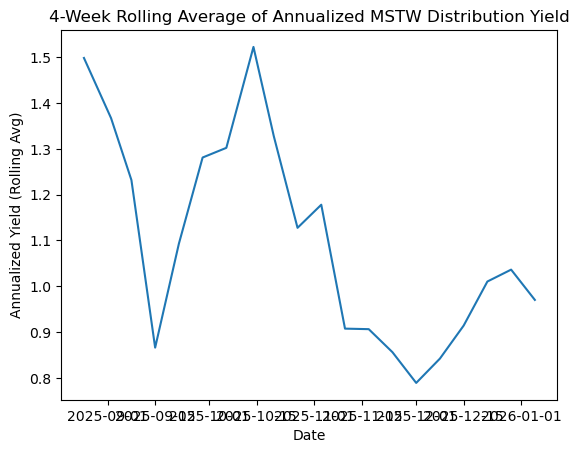

In [162]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure sorted by date
df = df.sort_values("ex_date").copy()

# Annualize weekly yield
df["annualized_yield"] = df["weekly_yield"] * 52

# Rolling average (choose window)
window = 4   # try 4, 6, or 8
df["annualized_yield_roll"] = df["annualized_yield"].rolling(window).mean()

# Plot
plt.figure()
plt.plot(df["ex_date"], df["annualized_yield_roll"])
plt.xlabel("Date")
plt.ylabel("Annualized Yield (Rolling Avg)")
plt.title(f"{window}-Week Rolling Average of Annualized MSTW Distribution Yield")
plt.show()


In [163]:
import numpy as np

df = df.sort_values("ex_date").copy()

t = np.arange(len(df))          # weekly time index: 0,1,2,...
logp = np.log(df["price"].values)

window = 8  # last 8 weeks
sub = df.tail(window)

t = np.arange(len(sub))
lambda_week = -np.polyfit(t, np.log(sub["price"]), 1)[0]
lambda_annual = lambda_week * 52


print("Weekly decay:", lambda_week)
print("Annualized decay:", lambda_annual)


Weekly decay: 0.033391382571428325
Annualized decay: 1.736351893714273


In [164]:
P0 = df["price"].iloc[-1]
y_ann = df["annualized_yield_roll"].iloc[-1]
lam = lambda_annual

expected_cash = P0 * y_ann * (1 - np.exp(-lam)) / lam
print("Forward-adjusted expected annual cash:", expected_cash)


Forward-adjusted expected annual cash: 4.827222824880817


In [165]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression

def compute_beta(etf: str, underlying: str, *, start="2024-01-01", end=None, use_adj=True):
    etf = etf.upper().strip()
    underlying = underlying.upper().strip()

    px = yf.download([etf, underlying], start=start, end=end, auto_adjust=False, progress=False)

    # yfinance returns either a MultiIndex column or single columns depending on tickers
    col = "Adj Close" if use_adj else "Close"
    if isinstance(px.columns, pd.MultiIndex):
        if col not in px.columns.get_level_values(0):
            raise ValueError(f"Price column '{col}' not found. Available: {sorted(set(px.columns.get_level_values(0)))}")
        prices = px[col].copy()
    else:
        # single ticker case (shouldn't happen here but be defensive)
        prices = px[[col]].copy()
        prices.columns = [etf]

    # Ensure both tickers exist
    missing = [t for t in [etf, underlying] if t not in prices.columns]
    if missing:
        raise ValueError(f"Missing price series for: {missing}. Columns present: {prices.columns.tolist()}")

    # Compute returns
    ret = prices.pct_change()

    # IMPORTANT: only drop rows where either is missing (pairwise), not entire frame arbitrarily
    pair = ret[[etf, underlying]].dropna(how="any")

    # Diagnostics
    if pair.empty:
        # give helpful debug info
        info = {
            "etf_non_na_prices": int(prices[etf].notna().sum()),
            "und_non_na_prices": int(prices[underlying].notna().sum()),
            "overlap_non_na_rows": int(ret[[etf, underlying]].dropna(how="any").shape[0]),
            "price_date_range": (str(prices.index.min().date()), str(prices.index.max().date())) if len(prices.index) else None,
        }
        raise ValueError(
            f"No overlapping return samples for {etf} vs {underlying}. "
            f"Likely ETF is new or missing data. Diagnostics: {info}"
        )

    X = pair[[underlying]].values  # shape (n,1)
    y = pair[[etf]].values         # shape (n,1)

    model = LinearRegression().fit(X, y)
    beta = float(model.coef_[0][0])
    alpha = float(model.intercept_[0])

    return beta, alpha, pair

# Example
beta, alpha, ret = compute_beta("PLTY", "PLTR", start="2025-01-01")
print("n samples:", len(ret))
print("beta:", beta, "alpha:", alpha)

beta, alpha, ret = compute_beta("GOOY", "GOOGL")
print("Beta (GOOY vs GOOGL):", beta)
print("Alpha:", alpha)

beta, alpha, ret = compute_beta("MSTW", "MSTR")
print("Beta (MSTW vs MSTR):", beta)
print("Alpha:", alpha)


n samples: 261
beta: 0.8060783586817214 alpha: -0.0005574335075571066
Beta (GOOY vs GOOGL): 0.7427546632199218
Alpha: -0.0001336730589545762
Beta (MSTW vs MSTR): 1.1871377782702646
Alpha: -0.0007648217913837404


PLTR / PLTY
Mean CAGR: 0.3793112147857283
P10: 0.2452569898453136
P50 (median): 0.3737930140110266
P90: 0.5200051954990539


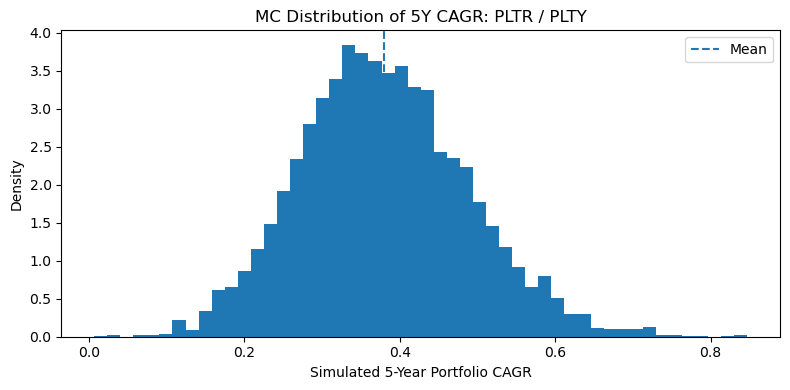

In [166]:
etf = "PLTY"
pair_to_view = results_df_mc[results_df_mc["ETF"] == etf].iloc[0]

print(pair_to_view["Underlying"], "/", pair_to_view["ETF"])

# Rebuild daily returns for this pair
und = pair_to_view["Underlying"]
etf = pair_to_view["ETF"]

long_tr = get_total_return_series(und, start=None, end=None)
etf_tr  = get_total_return_series(etf, start=None, end=None)

# Use the same trading_days as before
trading_days = 252

# Recompute leg returns
_, long_ret  = compute_leg_stats(long_tr, trading_days=trading_days)
_, etf_ret   = compute_leg_stats(etf_tr,  trading_days=trading_days)

# Pull the pair-specific weights and borrow from results_df_mc
w_long_pair   = float(pair_to_view["w_long"])
w_short_pair  = float(pair_to_view["w_short"])
borrow_annual = float(pair_to_view["borrow_annual"])

# Set MC parameters (match what you used in analyze_pairs_with_mc)
horizon_days = 252 * 5
n_sims = 5000

# Run alternative MC for this pair
sim_cagrs = simulate_pair_mc_full(
    long_ret=long_ret,
    etf_ret=etf_ret,
    w_long=w_long_pair,
    w_short=w_short_pair,
    borrow_annual=borrow_annual,
    horizon_days=horizon_days,
    n_sims=n_sims,
    random_state=42,
    trading_days=trading_days,
)

# Quick summary
print("Mean CAGR:", sim_cagrs.mean())
print("P10:", np.percentile(sim_cagrs, 10))
print("P50 (median):", np.percentile(sim_cagrs, 50))
print("P90:", np.percentile(sim_cagrs, 90))

# Plot distribution
plt.figure(figsize=(8, 4))
plt.hist(sim_cagrs, bins=50, density=True)
plt.axvline(sim_cagrs.mean(), linestyle="--", label="Mean")
plt.xlabel("Simulated 5-Year Portfolio CAGR")
plt.ylabel("Density")
plt.title(f"MC Distribution of 5Y CAGR: {und} / {etf}")
plt.legend()
plt.tight_layout()
plt.show()


In [167]:
# --- 1. Extract pairs ---

ym_df["Underlying"] = ym_df["Underlying"].str.replace(".", "-", regex=False)
pairs = list(zip(ym_df["Underlying"], ym_df["ETF"]))

# --- 2. Load all TR price series into a unified DataFrame ---
price_dict = {}

for und, etf in pairs:
    # Get total return series
    tr_und = get_total_return_series(und)
    tr_etf = get_total_return_series(etf)
    
    if not tr_und.empty:
        price_dict[f"{und}_TR"] = tr_und
    if not tr_etf.empty:
        price_dict[f"{etf}_TR"] = tr_etf

# Combine into one aligned DataFrame, KEEPING all dates
prices = pd.DataFrame(price_dict)   # <-- no dropna here
prices.tail()


,ABNB_TR,ABNY_TR,AI_TR,AIYY_TR,AMD_TR,AMDY_TR,AMZN_TR,AMZY_TR,AAPL_TR,APLY_TR,BABA_TR,BABO_TR,BRK-B_TR,BRKC_TR,COIN_TR,CONY_TR,CRCL_TR,CRCO_TR,CVNA_TR,CVNY_TR,DIS_TR,DISO_TR,DKNG_TR,DRAY_TR,META_TR,FBY_TR,GME_TR,GMEY_TR,GOOGL_TR,GOOY_TR,HIMS_TR,HIYY_TR,HOOD_TR,HOOY_TR,JPM_TR,JPMO_TR,MARA_TR,MARO_TR,MRNA_TR,MRNY_TR,MSFT_TR,MSFO_TR,MSTR_TR,MSTY_TR,NFLX_TR,NFLY_TR,NVDA_TR,NVDY_TR,PLTR_TR,PLTY_TR,PYPL_TR,PYPY_TR,RBLX_TR,RBLY_TR,RDDT_TR,RDYY_TR,SMCI_TR,SMCY_TR,SNOW_TR,SNOY_TR,TSLA_TR,TSLY_TR,TSM_TR,TSMY_TR,XOM_TR,XOMO_TR,XYZ_TR,XYZY_TR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2026-01-13 00:00:00-05:00,140.070007,92.401238,13.560,70.916725,220.970001,165.131676,242.600006,36.585692,340.602597,26.830898,175.967005,33.090402,495.239990,49.533439,252.690002,363.584771,83.459999,33.278518,468.549988,87.781163,183.541080,25.657987,34.049999,39.704821,635.462342,33.735176,31.287996,43.320369,338.529334,36.081643,32.200001,30.369327,120.239998,92.516427,1506.393345,28.346307,10.95,22.539931,39.599998,79.163341,768.890754,29.745746,172.990005,210.667596,90.320000,33.861038,202.644011,78.339401,178.960007,138.215412,56.691733,105.549341,84.800003,37.960358,258.929993,52.720024,28.600000,28.768825,209.389999,30.404988,447.200012,320.580525,661.476330,32.840013,2238.889156,21.446752,67.260002,129.134569
2026-01-14 00:00:00-05:00,132.789993,88.313037,13.910,72.649420,223.600006,166.967453,236.649994,35.749911,339.180434,26.767916,179.012000,33.667292,493.149994,49.644891,255.860001,366.337928,84.800003,33.663779,458.609985,86.392707,184.434572,25.703080,34.320000,39.996572,619.784463,32.895296,31.287996,43.405744,338.398339,36.105366,31.320000,29.636405,119.669998,92.667879,1491.712193,28.070615,11.11,22.673462,40.580002,80.461807,750.447295,29.229809,179.330002,216.377297,88.550003,33.506782,199.732116,77.526192,178.399994,138.188209,57.794294,106.941375,82.870003,37.112263,252.380005,52.040945,28.270000,28.459091,206.160004,30.057349,439.200012,317.090250,653.287999,32.521951,2303.645956,21.999870,65.610001,125.319989
2026-01-15 00:00:00-05:00,132.600006,88.500973,13.530,71.308643,227.919998,166.622147,238.179993,36.008734,336.897137,26.604159,180.097239,34.004194,492.619995,49.436472,239.279999,346.524013,76.599998,31.062609,460.880005,86.840096,184.239634,25.900631,35.459999,41.530923,625.101012,33.253644,31.794082,44.200947,335.315031,35.958288,31.230000,29.699807,110.349998,87.026398,1498.447185,28.266745,10.66,22.136671,39.360001,79.024835,746.003877,29.009545,170.910004,209.184395,88.050003,33.344412,203.996359,78.908651,177.070007,137.516178,56.872153,107.074708,84.650002,38.021400,228.750000,47.360527,29.420000,29.501256,207.740005,30.290001,438.570007,317.613782,682.306660,33.533787,2284.714443,21.833934,64.919998,125.613711
2026-01-16 00:00:00-05:00,130.660004,87.188764,13.040,69.348693,231.830002,169.002467,239.119995,36.090201,333.400441,26.309259,174.270658,33.006121,493.290009,49.323586,241.149994,348.870092,78.610001,31.345730,443.119995,83.196768,180.649379,25.408928,32.619999,38.170041,624.547213,33.197378,31.407075,43.639664,332.513855,35.767273,31.379999,29.686994,108.739998,85.512734,1514.000449,28.475027,11.36,22.895332,41.830002,82.578975,751.231395,28.989621,173.710007,211.910586,88.000000,33.374105,203.102060,78.908651,170.960007,132.935043,57.022500,106.259103,87.279999,38.867775,231.009995,47.919116,32.639999,31.526936,210.380005,30.424504,437.500000,317.701904,683.824454,33.533787,2298.161127,21.993607,65.949997,125.651807
2026-01-20 00:00:00-05:00,131.710007,86.752013,12.753,67.305347,238.581894,172.661093,234.845001,35.456381,328.716426,25.929893,174.160031,32.901671,487.105011,48.821731,232.651596,338.356174,75.779999,30.792967,443.369995,83.641078,179.707153,25.210521,31.547100,37.109762,613.818364,32.663124,31.317616,43.487039,328.891468,35.313617,30.609699,29.251362,108.236603,84.976239,1501.984135,28.276043,10.71,21.906362,42.389999,83.544303,742.295602,28.730607,162.160004,199

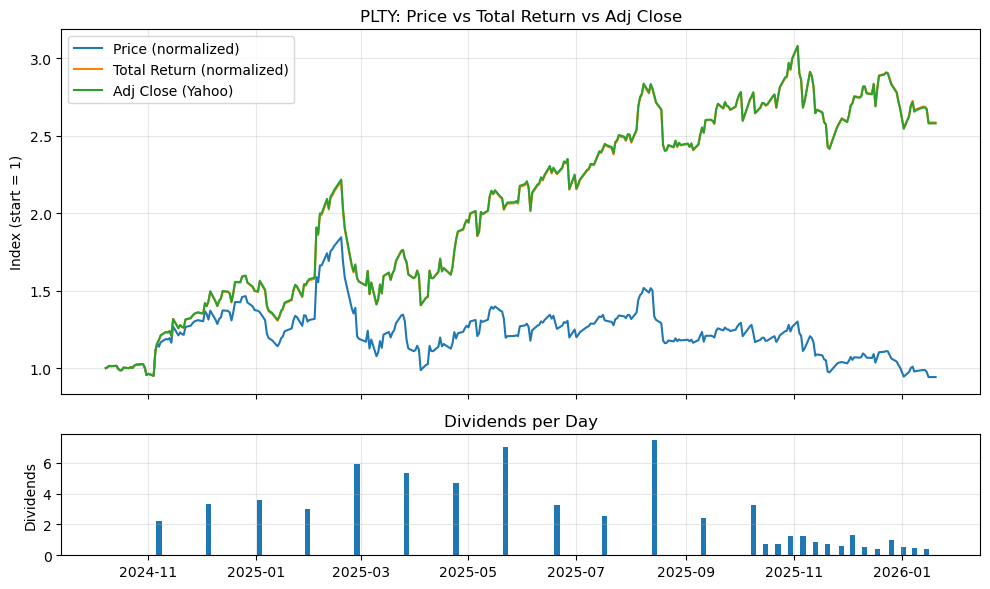

                               Close  Dividends
Date                                           
2024-11-07 00:00:00-05:00  58.577000      2.201
2024-12-05 00:00:00-05:00  67.547997      3.348
2025-01-03 00:00:00-05:00  69.989998      3.589
2025-01-30 00:00:00-05:00  66.860001      2.983
2025-02-27 00:00:00-05:00  62.000000      5.938
Price-only return: -0.01706551121768307
Total-return step: 0.019867735998939873


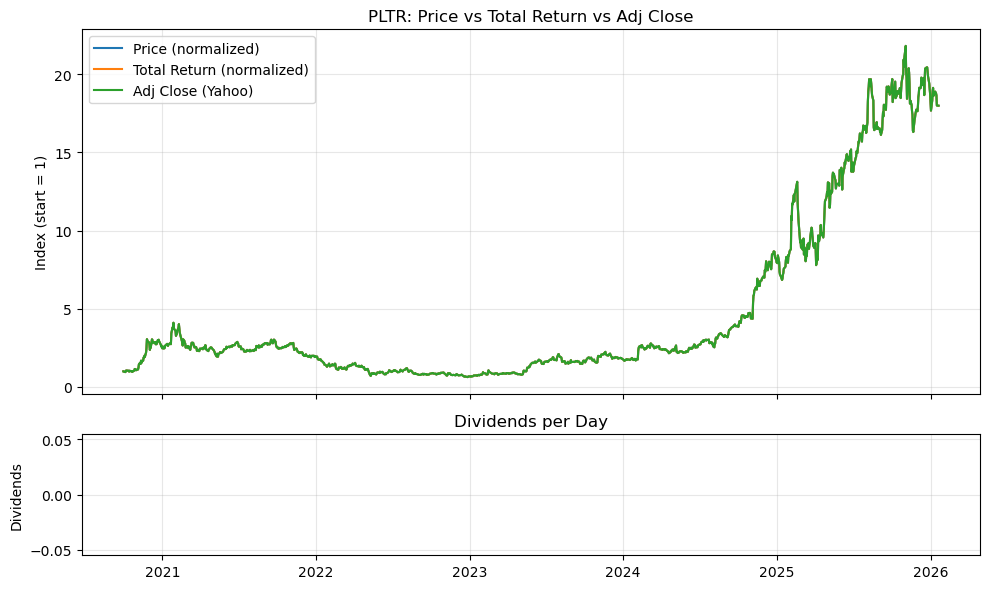

In [168]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

def debug_tr_vs_adj(ticker, start=None, end=None):
    t = yf.Ticker(ticker)

    # Raw (unadjusted) with dividends
    raw = t.history(period='max',
                    auto_adjust=False, actions=True)

    # Yahoo's adjusted series (adjusted for splits + dividends)
    adj = t.history(period='max',
                    auto_adjust=True, actions=False)

    if raw.empty or adj.empty:
        print(f"No data for {ticker}")
        return

    close = raw["Close"]
    divs  = raw.get("Dividends", pd.Series(0.0, index=raw.index))

    # Your TR logic
    divs = divs.reindex(close.index, fill_value=0.0)
    rel = (close + divs) / close.shift(1)
    rel.iloc[0] = 1.0
    tr = close.iloc[0] * rel.cumprod()
    tr.name = "TR"

    df = pd.DataFrame({
        "Close": close,
        "TR": tr,
        "AdjClose": adj["Close"],
        "Dividends": divs,
    }).dropna(subset=["Close", "TR", "AdjClose"])

    # Normalize all price-like series to 1 at start
    df["Close_norm"]    = df["Close"]    / df["Close"].iloc[0]
    df["TR_norm"]       = df["TR"]       / df["TR"].iloc[0]
    df["AdjClose_norm"] = df["AdjClose"] / df["AdjClose"].iloc[0]

    # --- Plot ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6),
                                   sharex=True,
                                   gridspec_kw={"height_ratios": [3, 1]})

    ax1.plot(df.index, df["Close_norm"],    label="Price (normalized)")
    ax1.plot(df.index, df["TR_norm"],       label="Total Return (normalized)")
    ax1.plot(df.index, df["AdjClose_norm"], label="Adj Close (Yahoo)")
    ax1.set_ylabel("Index (start = 1)")
    ax1.set_title(f"{ticker}: Price vs Total Return vs Adj Close")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.bar(df.index, df["Dividends"], width=3, align="center")
    ax2.set_ylabel("Dividends")
    ax2.set_title("Dividends per Day")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df

# Example for PLTY
df_plty = debug_tr_vs_adj("PLTY")

# Show rows where there is a non-zero dividend
div_days = df_plty[df_plty["Dividends"] != 0]
print(div_days[["Close", "Dividends"]].head())

# For a single ex-div day, compare price vs TR return
d = div_days.index[0]
prev = df_plty.loc[:d].iloc[-2]  # previous trading day
curr = df_plty.loc[d]

price_ret = curr["Close"] / prev["Close"] - 1
tr_ret    = (curr["Close"] + curr["Dividends"]) / prev["Close"] - 1

print("Price-only return:", price_ret)
print("Total-return step:", tr_ret)

df_plty = debug_tr_vs_adj("PLTR")



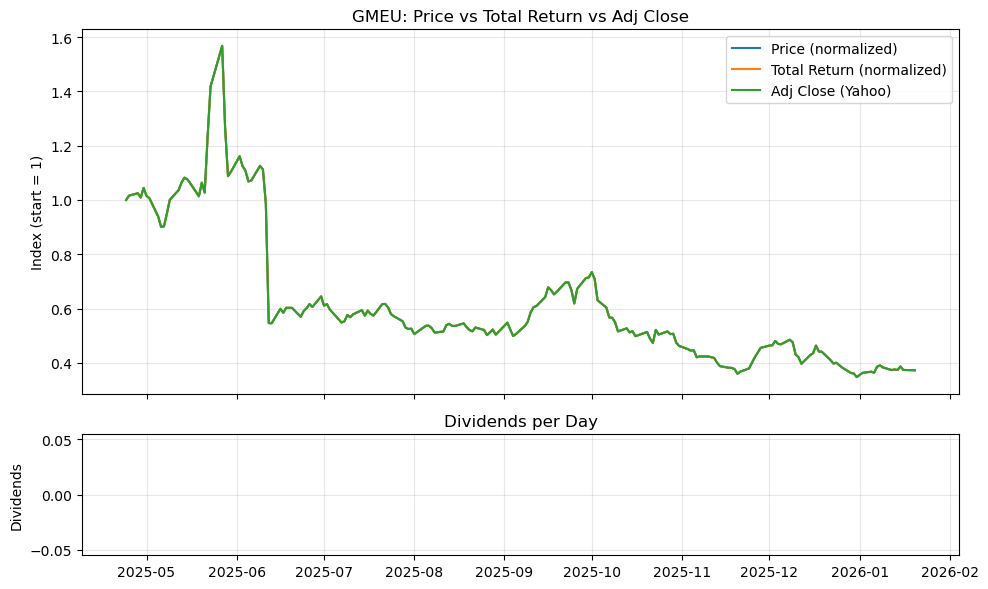

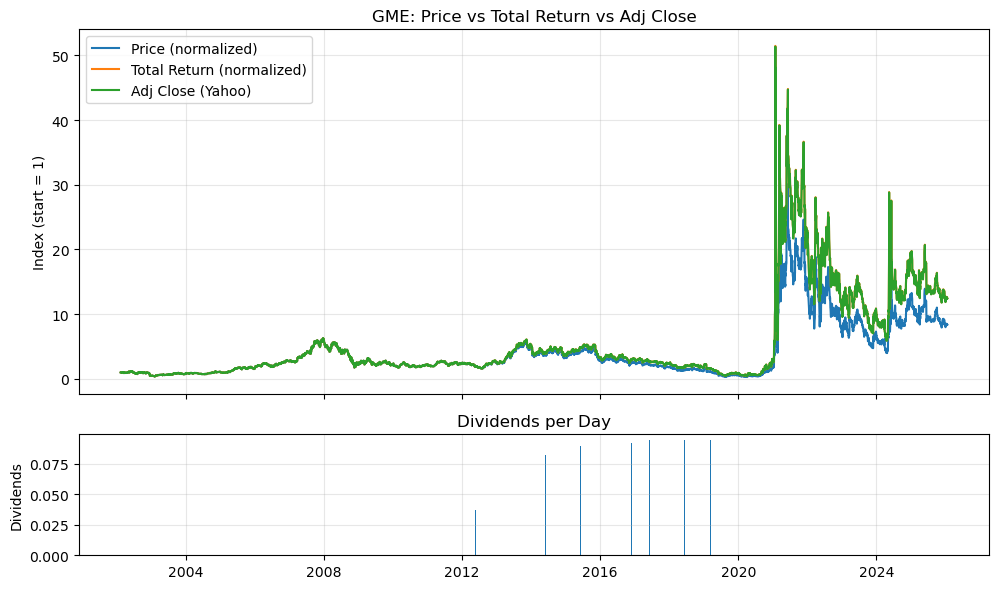

In [169]:
def debug_tr_vs_adj(ticker, start=None, end=None):
    t = yf.Ticker(ticker)

    # Raw (unadjusted) with dividends
    raw = t.history(period='max',
                    auto_adjust=False, actions=True)

    # Yahoo's adjusted series (adjusted for splits + dividends)
    adj = t.history(period='max',
                    auto_adjust=True, actions=False)

    if raw.empty or adj.empty:
        print(f"No data for {ticker}")
        return

    close = raw["Close"]
    divs  = raw.get("Dividends", pd.Series(0.0, index=raw.index))

    # Your TR logic
    divs = divs.reindex(close.index, fill_value=0.0)
    rel = (close + divs) / close.shift(1)
    rel.iloc[0] = 1.0
    tr = close.iloc[0] * rel.cumprod()
    tr.name = "TR"

    df = pd.DataFrame({
        "Close": close,
        "TR": tr,
        "AdjClose": adj["Close"],
        "Dividends": divs,
    }).dropna(subset=["Close", "TR", "AdjClose"])

    # Normalize all price-like series to 1 at start
    df["Close_norm"]    = df["Close"]    / df["Close"].iloc[0]
    df["TR_norm"]       = df["TR"]       / df["TR"].iloc[0]
    df["AdjClose_norm"] = df["AdjClose"] / df["AdjClose"].iloc[0]

    # --- Plot ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6),
                                   sharex=True,
                                   gridspec_kw={"height_ratios": [3, 1]})

    ax1.plot(df.index, df["Close_norm"],    label="Price (normalized)")
    ax1.plot(df.index, df["TR_norm"],       label="Total Return (normalized)")
    ax1.plot(df.index, df["AdjClose_norm"], label="Adj Close (Yahoo)")
    ax1.set_ylabel("Index (start = 1)")
    ax1.set_title(f"{ticker}: Price vs Total Return vs Adj Close")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.bar(df.index, df["Dividends"], width=3, align="center")
    ax2.set_ylabel("Dividends")
    ax2.set_title("Dividends per Day")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df

# Example for GMEU
df_gmeu = debug_tr_vs_adj("GMEU")

# Show rows where there is a non-zero dividend
div_days = df_gmeu[df_gmeu["Dividends"] != 0]
# print(div_days[["Close", "Dividends"]].head())

# # For a single ex-div day, compare price vs TR return
# d = div_days.index[0]
# prev = df_gmeu.loc[:d].iloc[-2]  # previous trading day
# curr = df_gmeu.loc[d]

# price_ret = curr["Close"] / prev["Close"] - 1
# tr_ret    = (curr["Close"] + curr["Dividends"]) / prev["Close"] - 1

# print("Price-only return:", price_ret)
# print("Total-return step:", tr_ret)

df_gme = debug_tr_vs_adj("GME")



In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


# -----------------------------
# Helpers (your existing ones)
# -----------------------------
def get_total_return_series(ticker, start=None, end=None):
    """
    Long-only total return price series for SINGLE-NAME EQUITIES:
    TR_t = TR_{t-1} * (Close_t + Div_t) / Close_{t-1}

    (Good for common stocks; for ETFs we prefer Adj Close via get_total_return_series_etf.)
    """
    t = yf.Ticker(ticker)
    df = t.history(period="max", auto_adjust=False, actions=True)

    if df.empty or "Close" not in df.columns:
        print(f"[WARN] No Yahoo data for {ticker}")
        return pd.Series(dtype=float)

    if start is not None:
        df = df[df.index >= pd.to_datetime(start)]
    if end is not None:
        df = df[df.index <= pd.to_datetime(end)]

    if df.empty:
        print(f"[WARN] No data in range for {ticker}")
        return pd.Series(dtype=float)

    close = df["Close"]
    divs = df.get("Dividends", pd.Series(0.0, index=df.index)).reindex(close.index, fill_value=0.0)

    rel = (close + divs) / close.shift(1)
    rel.iloc[0] = 1.0

    tr_price = close.iloc[0] * rel.cumprod()
    tr_price.name = ticker + "_TR"
    return tr_price


def get_total_return_series_etf(ticker):
    """
    Total return proxy for ETFs/levered ETFs using Adj Close.
    This avoids dividend/distribution artifacts in (Close + Dividends) for ETFs.
    """
    df = yf.Ticker(ticker).history(period="max", auto_adjust=False, actions=True)
    if df.empty or "Adj Close" not in df.columns:
        print(f"[WARN] No Yahoo Adj Close data for {ticker}")
        return pd.Series(dtype=float)

    tr = df["Adj Close"].dropna()
    tr.name = ticker + "_TR"
    return tr


def compute_leg_stats(tr_price: pd.Series, trading_days: int = 252):
    """
    Given a total-return price series (long), compute stats and daily returns.
    Returns:
        stats: dict with cagr, vol_annual, etc.
        ret:   daily simple returns
    """
    tr_price = tr_price.dropna()
    if len(tr_price) < 3:
        return None, pd.Series(dtype=float)

    ret = tr_price.pct_change().dropna()
    T = len(ret)

    cumulative = (1 + ret).prod()
    cagr = cumulative ** (trading_days / T) - 1.0
    vol_annual = ret.std() * np.sqrt(trading_days)

    stats = {"cagr": cagr, "vol_annual": vol_annual, "n_obs": T}
    return stats, ret


# -----------------------------
# Constant-shares portfolio returns (LET GROSS DRIFT)
# -----------------------------
def portfolio_returns_constant_shares(
    tr_long: pd.Series,
    tr_short: pd.Series,
    *,
    q_long: float,
    q_short: float,           # negative for short
    borrow_annual: float = 0.0,
    trading_days: int = 252,
) -> pd.Series:
    """
    Constant-shares PnL model:
      - Shares fixed after entry
      - Gross can drift
      - Borrow charged daily on SHORT NOTIONAL (approx): |q_short| * Price_short(t-1) * borrow_daily

    Return definition:
      ret_t = pnl_t / equity_{t-1}, with equity0 defined from initial gross notional.

    Equity convention:
      equity0 = initial gross notional (common for levered sleeves; makes returns interpretable)
    """
    px = pd.concat([tr_long.rename("L"), tr_short.rename("S")], axis=1).dropna()
    if len(px) < 3:
        return pd.Series(dtype=float)

    # Dollar PnL each day (TR prices used as "price" proxy)
    dL = px["L"].diff()
    dS = px["S"].diff()
    pnl = q_long * dL + q_short * dS  # q_short is negative for a short

    # Borrow drag on short notional (approx, charged on yesterday's short notional)
    borrow_daily = borrow_annual / trading_days
    short_notional_prev = (abs(q_short) * px["S"].shift(1))
    pnl = pnl - short_notional_prev * borrow_daily

    pnl = pnl.dropna()

    # Equity path (start equity = initial gross notional at entry)
    equity0 = 1.0

    equity = equity0 + pnl.cumsum()

    # Return = pnl / prior equity
    ret = pnl / equity.shift(1)
    ret.name = "port_ret"
    return ret.dropna()


# -----------------------------
# Share count calculator (ENTRY GROSS MATCHES TARGET)
# -----------------------------
def compute_share_counts_entry(
    tr_long: pd.Series,
    tr_short: pd.Series,
    *,
    base_w_long: float = 1.0,
    base_w_short: float = -0.5,
    target_gross: float = 4.0,
    equity: float = 1.0,
):
    """
    Compute constant share counts such that at ENTRY:
      abs(long_notional) + abs(short_notional) == target_gross * equity
    while preserving the long/short ratio base_w_long : base_w_short.

    Shares will scale linearly with target_gross (e.g. 4x gross => 4x shares),
    and gross will drift thereafter (no rebalance).
    """
    # Align prices so entry is the same date for both legs
    px = pd.concat([tr_long.rename("L"), tr_short.rename("S")], axis=1).dropna()
    if len(px) < 3:
        raise ValueError("Not enough overlapping price history to compute share counts.")

    P0L = float(px["L"].iloc[0])
    P0S = float(px["S"].iloc[0])

    gross0 = abs(base_w_long) + abs(base_w_short)
    if gross0 <= 0:
        raise ValueError("Base weights produce zero gross exposure.")
    if target_gross <= 0:
        raise ValueError("target_gross must be > 0.")
    if equity <= 0:
        raise ValueError("equity must be > 0.")

    k = target_gross / gross0
    wL = base_w_long * k
    wS = base_w_short * k  # negative

    # Dollar exposures at entry (per equity)
    dollar_long = equity * wL
    dollar_short = equity * wS  # negative

    # Convert to shares
    q_long = dollar_long / P0L
    q_short = dollar_short / P0S  # negative

    gross_entry = abs(q_long * P0L) + abs(q_short * P0S)

    return {
        "q_long": float(q_long),
        "q_short": float(q_short),
        "w_long": float(wL),
        "w_short": float(wS),
        "entry_date": px.index[0],
        "gross_entry": float(gross_entry),
        "px_aligned": px,
    }


# -----------------------------
# Full pair backtest (constant shares)
# -----------------------------
def run_pair_backtest_tr(
    underlying: str,
    etf: str,
    *,
    base_w_long: float = 1.0,
    base_w_short: float = -0.5,
    target_gross: float = 4.0,
    borrow_annual: float = 0.0,
    equity0: float = 1.0,
    TRADING_DAYS: int = 252,
    log_scale: bool = True,
    make_plot: bool = True,
    use_etf_adjclose: bool = True,   # set False if you insist on Close+Div for the ETF (not recommended)
):
    # --- Fetch TR series ---
    tr_und = get_total_return_series(underlying)

    if use_etf_adjclose:
        tr_etf = get_total_return_series_etf(etf)
    else:
        tr_etf = get_total_return_series(etf)

    if tr_und.empty:
        raise ValueError(f"No TR data for {underlying}")
    if tr_etf.empty:
        raise ValueError(f"No TR data for {etf}")

    # --- Restrict to ETF life (calendar window) ---
    start_dt = tr_etf.index.min()
    end_dt = tr_etf.index.max()
    tr_und = tr_und.loc[start_dt:end_dt]
    tr_etf = tr_etf.loc[start_dt:end_dt]

    # --- Align to common dates (critical) ---
    px = pd.concat([tr_und.rename("und"), tr_etf.rename("etf")], axis=1).dropna()
    if len(px) < 3:
        raise ValueError("No overlapping dates between underlying and ETF after windowing/alignment.")

    tr_und_win = px["und"]
    tr_etf_win = px["etf"]

    # --- Compute entry shares that match target gross initially ---
    entry = compute_share_counts_entry(
        tr_long=tr_und_win,
        tr_short=tr_etf_win,
        base_w_long=base_w_long,
        base_w_short=base_w_short,
        target_gross=target_gross,
        equity=equity0,
    )
    q_long = entry["q_long"]
    q_short = entry["q_short"]
    w_long = entry["w_long"]
    w_short = entry["w_short"]

    # Sanity: initial gross
    P0L = float(tr_und_win.iloc[0])
    P0S = float(tr_etf_win.iloc[0])
    gross_entry = abs(q_long * P0L) + abs(q_short * P0S)

    # --- Portfolio returns (constant shares) ---
    port_ret = portfolio_returns_constant_shares(
        tr_long=tr_und_win,
        tr_short=tr_etf_win,
        q_long=q_long,
        q_short=q_short,
        borrow_annual=borrow_annual,
        trading_days=TRADING_DAYS,
    )
    if port_ret.empty:
        raise ValueError("Portfolio returns are empty after computation.")

    port_nav = 100.0 * (1.0 + port_ret).cumprod()

    # --- Metrics (annualize with TRADING_DAYS) ---
    N = len(port_ret)
    ann_return = (port_nav.iloc[-1] / port_nav.iloc[0]) ** (TRADING_DAYS / max(N, 1)) - 1.0
    ann_vol = port_ret.std() * np.sqrt(TRADING_DAYS)

    roll_max = port_nav.cummax()
    dd = port_nav / roll_max - 1.0
    max_drawdown = float(dd.min())

    # --- Plot series (underlying/ETF at 1x, portfolio at levered entry shares) ---
    und_norm = 100.0 * (tr_und_win / tr_und_win.iloc[0])
    etf_norm = 100.0 * (tr_etf_win / tr_etf_win.iloc[0])

    if make_plot:
        plt.figure(figsize=(12, 6))
        plt.plot(und_norm.index, und_norm, label=f"{underlying} TR (100=start)", alpha=0.7)
        plt.plot(etf_norm.index, etf_norm, label=f"{etf} TR (100=start)", alpha=0.7)
        plt.plot(port_nav.index, port_nav, label="Pair NAV (100=start)", linewidth=2)

        if log_scale:
            plt.yscale("log")

        plt.title(
            f"{underlying} vs {etf} | Constant Shares | "
            f"Entry Weights: {w_long:.2f}, {w_short:.2f} | "
            f"Entry Gross: {gross_entry:.2f} | Borrow: {borrow_annual:.2%}"
        )
        plt.ylabel("Normalized Value" + (" (log scale)" if log_scale else ""))
        plt.xlabel("Date")
        plt.grid(True, alpha=0.25)
        plt.legend()
        plt.show()

        # Optional: gross drift plot (useful for debugging expectations)
        gross_t = (abs(q_long) * tr_und_win) + (abs(q_short) * tr_etf_win)
        plt.figure(figsize=(12, 3.5))
        plt.plot(gross_t.index, gross_t.values)
        plt.title("Gross Exposure Over Time (drifts; no rebalance)")
        plt.ylabel("Gross Notional (per $ equity0)")
        plt.grid(True, alpha=0.25)
        plt.show()

    return {
        "underlying": underlying,
        "etf": etf,
        "entry": {
            "entry_date": entry["entry_date"],
            "q_long": q_long,
            "q_short": q_short,
            "w_long": w_long,
            "w_short": w_short,
            "gross_entry": gross_entry,
        },
        "window": {"start": tr_und_win.index.min(), "end": tr_und_win.index.max(), "n_days": len(port_ret)},
        "series": {"underlying_norm": und_norm, "etf_norm": etf_norm, "port_nav": port_nav},
        "port_ret": port_ret,
        "metrics": {
            "ann_return": float(ann_return),
            "ann_vol": float(ann_vol),
            "max_drawdown": float(max_drawdown),
        },
    }




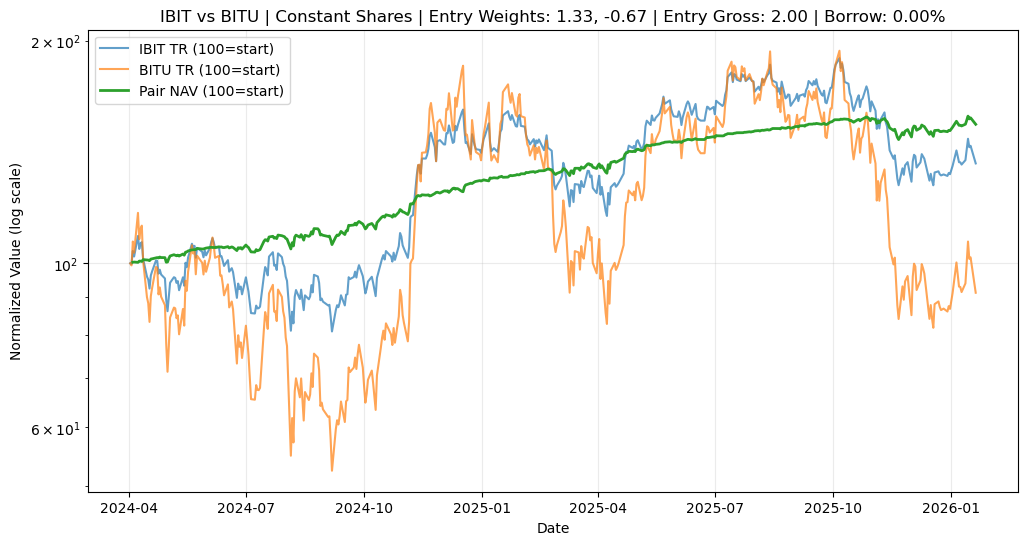

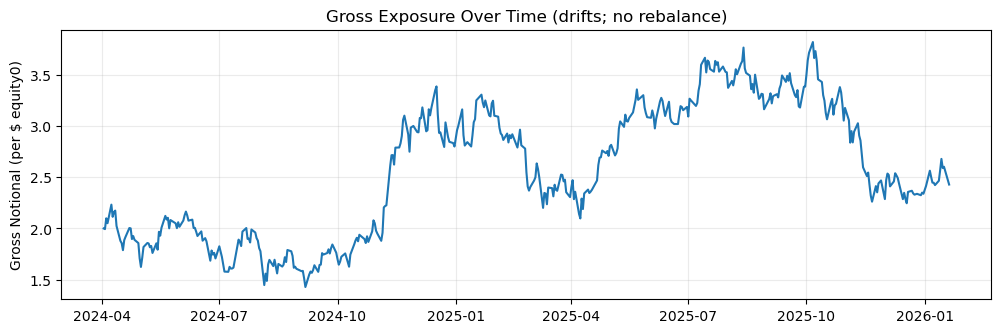

{'ann_return': 0.27228261076256,
 'ann_vol': 0.10924078900752572,
 'max_drawdown': -0.06837704392014465}

In [176]:
res = run_pair_backtest_tr(
    "IBIT", "BITU",
    target_gross=2.0,
    borrow_annual=0.00,   # example
    make_plot=True
)

res["metrics"]